# Big Data Coursework

## Data Processing and Machine Learning in the Cloud 

This is the **INM432 Big Data coursework 2021**. 
This coursework extended elements of **theory** and as well as **practical components** . 

## Code and Report

Your tasks are porting, parallelization, extension, evaluation, and theoretical reflection. 
The **coding tasks** are to be completed in (a copy of) **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that your **code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the  **textual answers** as indicated **in a separate PDF document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis. 


## Submission

Download and submit **the notebook** as an **.ipynb** file and also as a **shareable link** to your notebook (**don’t change the online version after submission**). 

Further, provide a **PDF report document** with answers containing text, plots, screenshots and tables. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  



Shareable Link to notebook: https://colab.research.google.com/drive/1Qo7bIWyn39okzb2V2OBs9rSMi59pk_ET?usp=sharing

## Introduction and Description

This part of the coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
What we will do here is **parallelise** the **pre-processing** and **machine learning** in the cloud and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains **4 sections**. Section 0 is only about settings and preparations for cloud computing and has no tasks for you (still read the code and comments). 
Section 1 contains tasks about data pre-processing. 
Sections 2 is about machine learning in the cloud. Section 3 contains the theoretical task for discussion. 


### Section 0

This section just contains some necessary code for setting up the environment.

### Section 1 
Section 1 is about reading image files into a dataset and creating TF Record files. 
We will start with an application of some pre-processing steps to a public “Flowers” dataset (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable and you can scale up later. 

In the **Getting Started** we will work through the code from *Fast and Lean Data Science*. There no task for you here, but you should work through this code before you do the rest.

In **Task 1** we are going to **measure the speed of reading data** in the cloud and we will **parallelise this in Spark**, using Google Cloud (GC) DataProc in **Task 2**. 
For large amounts of training data, the task of creating the TF Record files benefits from parallelisation, which we will also do in Spark in **Task 3**. 

### Section 2

In Section 2, we will **use  pre-processed data** (the public version of the one prepared in Section 1) to train a **deep neural network** in **Tensorflow 2/Keras**. 
We will use transfer learning to take advantage of existing trained models and reduce the training effort. 

We will use the GC **AI-Platform** (formerly Cloud ML) in **Task 4**. 
In contrast to the GC Compute Engine, we can use  machines with GPUs in AI-Platform with free credits. 

### Section 3

This section is about the theoretical discussion, based on to two papers, in **Task 5**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent**. The later tasks can mostly be addressed without needed the solution to the earlier ones.  

# Section 0: Set-up

You need to run the imports and authentication every time you work with this notebook. 
Use the local Spark installation and word count as needed. 

### Imports

We import some packages that we will need throughout.  For the cloud you will need separate import sections, that will need to be partly different from that below. 


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


### Cloud and Drive authentication

This is for authenticating with Google Drive and with GCS, so that we can create and use our own buckets and access DataProc and AI-Platform. 

This section starts with two interactive authentications.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW2` to use for this work. 
Then we'll set up the cloud environment, including a storage bucket.

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the cloud system to enable access to DataProc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to create a new Google Cloud project for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'big-data-cw-310516' ### Append -xxxx, where xxxx is your City login ###
### it seems that the project name here has the be all lower case.
!gcloud config set project $PROJECT
REGION = 'us-central1'
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
region = us-central1
[core]
account = jakobbrown@gmail.com
project = big-data-cw-310516
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409." This is not a problem, just a sign the bucket is already there. 
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://big-data-cw-310516-storage/...
ServiceException: 409 A Cloud Storage bucket named 'big-data-cw-310516-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title "Display utility functions [RUN THIS TO ACTIVATE]" { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

### Optional: Install Spark locally for quick testing

You can use the cell below to install a local spark as in the labs, to do quicker small-scale interactive testing. Using the cloud is still required for the final version. 


In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
#!tar -xzf spark-3.0.1-bin-hadoop2.7.tgz
!tar -xzf /content/drive/MyDrive/Big_Data/data/spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()
%cd /content
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
/content
3.0.1
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning with Keras/Tensorflow. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud services. 

## Getting started 

In this section, we get started based on the code from lecture 3 of the 'Fast and Lean Data Science' course to establish the task.


These are some variables with **settings for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
SHARDS = 16 # shards are partitiones into shards
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

###Read images and labels

We **read the image files** from a public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow**  has **functions** to process standard **image files**. The `decode_jpeg_and_label` function also extracts the label name from the path. 

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dataset1 = filepathDS.map(decode_jpeg_and_label)
for x in dataset1.take(1):
    print(x) # show what's in a data item

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.
(<tf.Tensor: shape=(240, 320, 3), dtype=uint8, numpy=
array([[[222, 223, 227],
        [223, 224, 228],
        [224, 225, 229],
        ...,
        [210, 211, 215],
        [209, 210, 214],
        [208, 209, 213]],

       [[222, 223, 227],
        [223, 224, 228],
        [224, 225, 229],
        ...,
        [210, 211, 215],
        [209, 210, 214],
        [208, 209, 213]],

       [[222, 223, 227],
        [223, 224, 228],
        [224, 225, 229],
        ...,
        [210, 211, 215],
        [209, 210, 214],
        [208, 209, 213]],

       ...,

       [[ 13,  22,   5],
        [ 13,  24,   7],
        [ 15,  26,   9],
        ...,
        [ 16,  21,   1],
        [ 26,  31,   9],
        [ 24,  32,   8]],

       [[ 20,  29,   8],
        [ 12,  24,   4],
        [ 10,  22,   2],
        ...,
        [ 19,  23,   8],
        [ 23,  27,  10],
        [  8,  13,   0]],

       [[

Now we can **have a look** at the images with one of the display functions. Note the **different aspect ratios**.

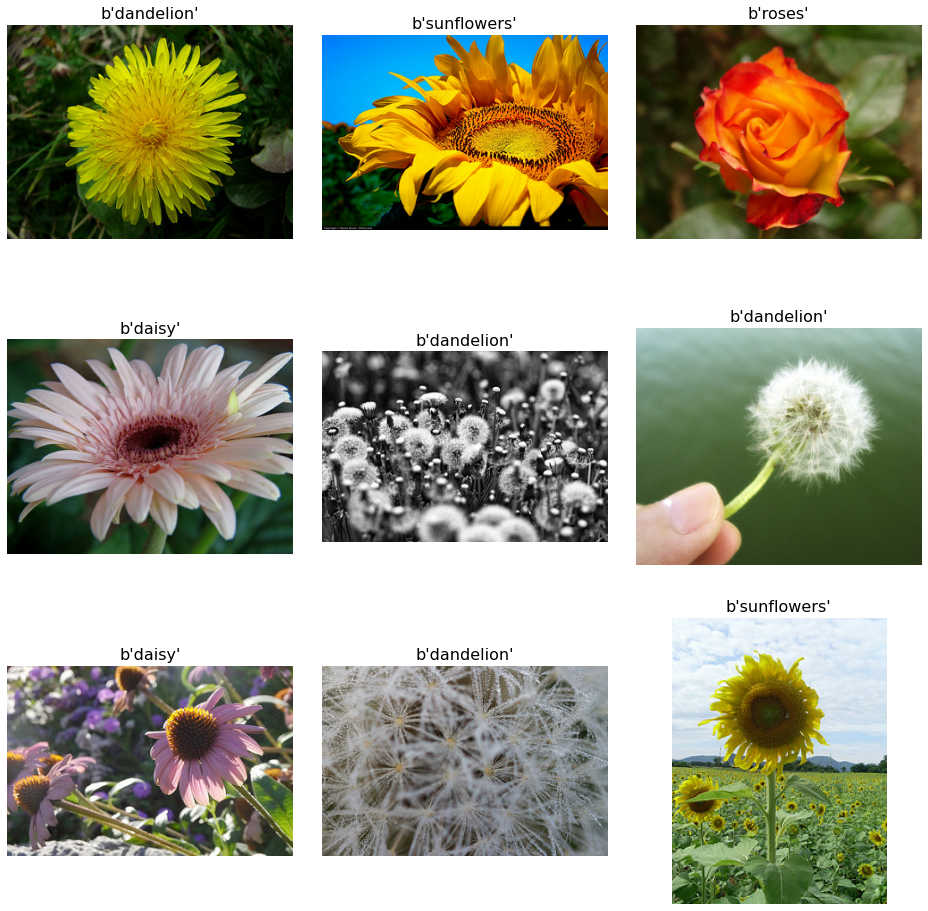

In [ ]:
display_9_images_from_dataset(dataset1)

### Resize and crop images to common size

Standard Neural Networks, like most machine learning algorithms, need **fixed size input items**. 
We achieve this here by resizing and cropping the images to a common target resolution.

In [ ]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset1.map(resize_and_crop_image)  

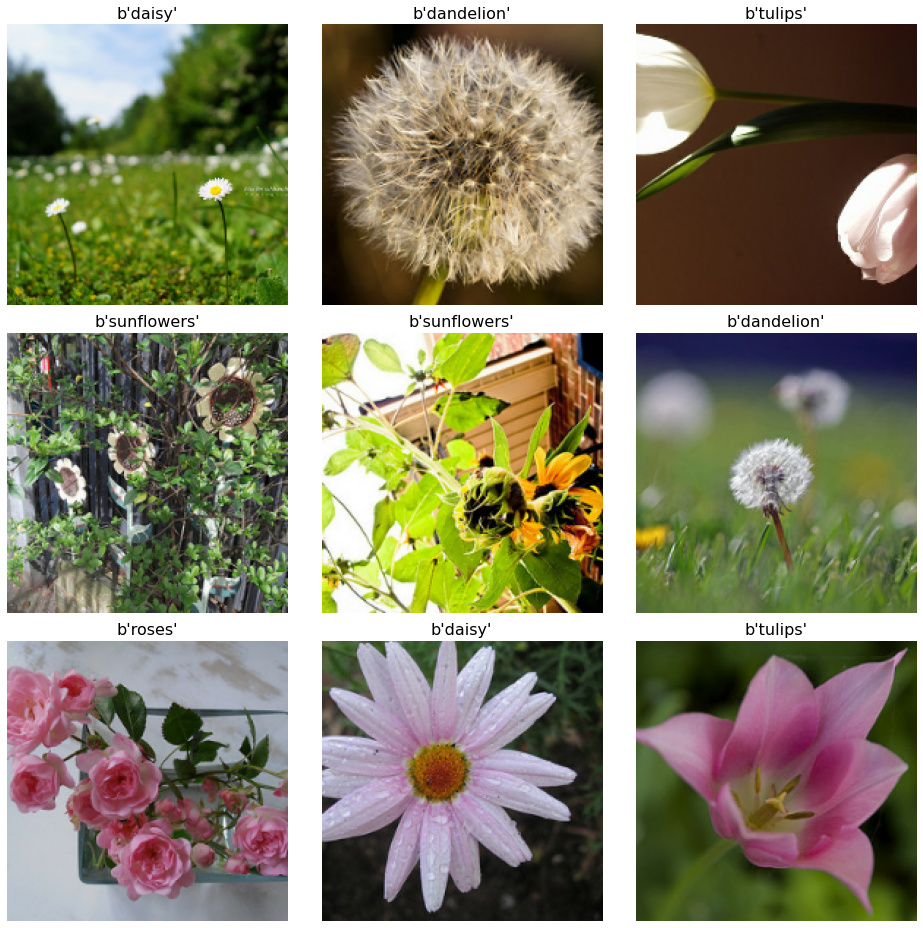

In [ ]:
display_9_images_from_dataset(dataset2)

Now test continuous reading from the dataset.

In [ ]:
batched_dataset = dataset2.batch(8)
sample_set = batched_dataset.take(20)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'roses', 'daisy', 'daisy', 'tulips'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'sunflowers', 'roses', 'dandelion', 'tulips', 'roses', 'roses', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['sunflowers', 'tulips', 'dandelion', 'tulips', 'roses', 'sunflowers', 'sunflowers', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'sunflowers', 'dandelion', 'tulips', 'dandelion', 'tulips', 'daisy', 'tulips'])
Image batch shape (8, 192, 192, 3), ['roses', 'dandelion', 'tulips', 'sunflowers', 'roses', 'daisy', 'roses', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['sunflowers', 'tulips', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'sunflowers', 'daisy'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'daisy', 'daisy', 'dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'tulips', 'daisy', 'roses', 'dandelion', 'daisy

## Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images

By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time**, but **saves network and disk bandwith**, especially when the data are **read multiple times**. 


In [ ]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image)
dataset4 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

In [ ]:
# This is a quick test to get an idea how long recompressions takes.  
BATCH_SIZE = 8
dataset4 = dataset3.batch(BATCH_SIZE)
BATCH_NUMBER = 3 # number of batches
test_set = dataset4.take(BATCH_NUMBER)
for image, label, height, width in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (8,), ['sunflowers', 'dandelion', 'daisy', 'dandelion', 'daisy', 'roses', 'roses', 'tulips'])
Image batch shape (8,), ['tulips', 'tulips', 'tulips', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'dandelion'])
Image batch shape (8,), ['tulips', 'roses', 'roses', 'sunflowers', 'tulips', 'roses', 'tulips', 'roses'])


### Write the dataset to TFRecord files

By writing **multiple samples into a single file**, we can make further speed gains.

There are **ready-made pre-processed data** versions available, e.g. here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for comparison and later use.

First we need to **define a location** where we want to put the file. 


In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. 

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]) #,        # one class in the list
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
tt0 = time.time()
filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
dataset1 = filenames.map(decode_jpeg_and_label)
dataset2 = dataset1.map(resize_and_crop_image)  
dataset3 = dataset2.map(recompress_image)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  # You need to change GCS_OUTPUT to your own bucket to actually create new files  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i] #, height.numpy()[i], width.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))
print("Total time: "+str(time.time()-tt0))

Writing TFRecords
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://big-data-cw-310516-storage/tfrecords-jpeg-192x192-2/flowers08-230.tfrec contai

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetDecoded = load_dataset(filenames)

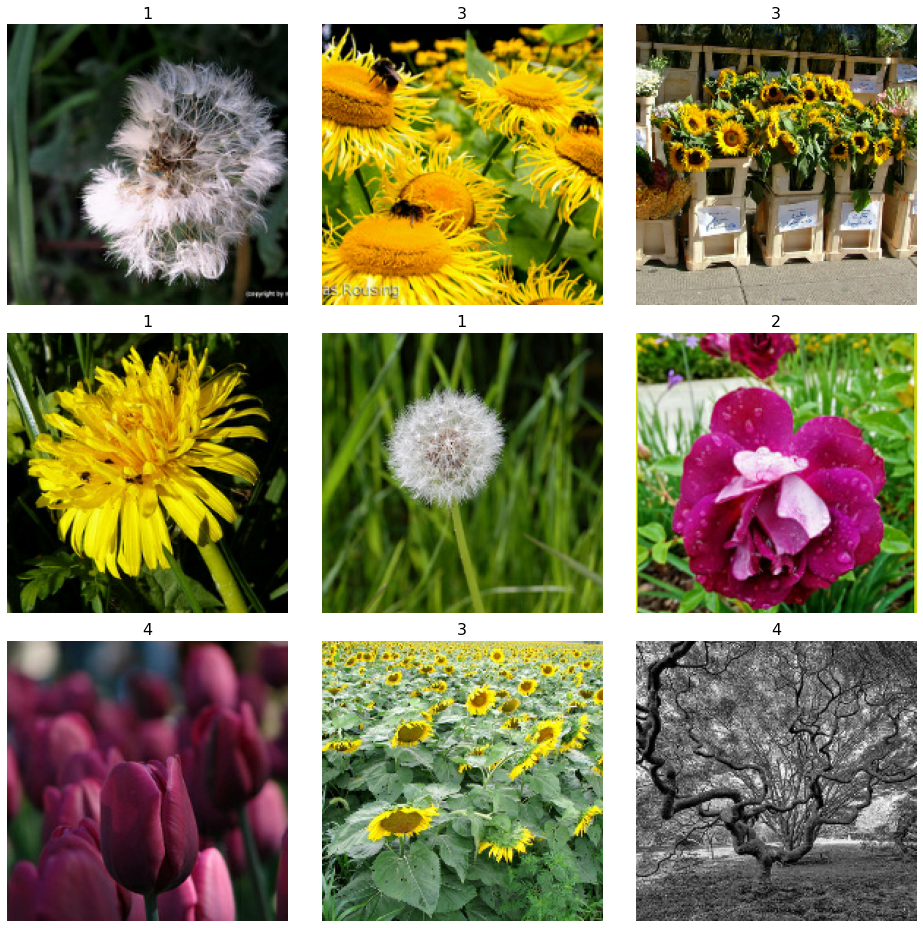

In [ ]:
display_9_images_from_dataset(datasetDecoded)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [ ]:
batched_dataset = datasetDecoded.batch(8)
sample_set = batched_dataset.take(20)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3'])
Image batch shape (8, 192, 192, 3), ['4', '3', '3', '0', '3', '4', '2', '2'])
Image batch shape (8, 192, 192, 3), ['3', '2', '0', '3', '4', '4', '4', '1'])
Image batch shape (8, 192, 192, 3), ['3', '2', '4', '4', '4', '3', '1', '3'])
Image batch shape (8, 192, 192, 3), ['4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (8, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1'])
Image batch shape (8, 192, 192, 3), ['2', '0', '1', '1', '1', '2', '0', '0'])
Image batch shape (8, 192, 192, 3), ['1', '4', '3', '1', '1', '2', '0', '2'])
Image batch shape (8, 192, 192, 3), ['3', '4', '2', '1', '1', '0', '0', '1'])
Image batch shape (8, 192, 192, 3), ['1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (8, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3'])
Image batch shape (8, 192, 192, 3), ['0', '1', '0', '0', '1', '1', '1', '0'])
Image batch shape (8, 192, 192, 3), ['1', '4', '3', '2', '2', '1

## Task1: Cloud Speed tests (8%)

We have just seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **understanding and quantifying this effect** better. 

### 1a): Speed test (5%)

Start by implementing **code for time measurement** to determine the **throughput in images per second**. 
Don't render the images, just print some basic information in order to **avoid measuring image rendering time**. 
It's useful to write to the null device for longer measurements (e.g. 
`print('string', \ file=open("/dev/null",mode='w')`).

Use batches ( `dataset.batch(batch_size)` ) and select a sample with (`dataset.take(batch_number)`). 
Good starting values are 8 and 10, i.e. we take 10 batches of 8 samples each. 

Use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset. 

**Vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be packaged into a **function** `time_configs()` that takes a dataset and the batch_sizes, batch_numbers, and number of repetitions as **arguments** to run a series of tests. 



In [ ]:
### CODING TASK ###

# intialising small test parameters
batch_sizes = [8, 16, 32] 
batch_numbers = [5, 10, 20] 
repetitions = [1,2,3] 


def time_configs(data, batch_sizes, batch_numbers, repetitions, dataset_type):

  # intialising list, which will be filled iteratively with the different combinations of parameters
  # along with their corresponding results in terms of throughput
  results = []
  

  # looping over all possible combinations of parameters
  for batch_size_idx, batch_size in enumerate(batch_sizes):
    for batch_number_idx, batch_number in enumerate(batch_numbers):
      for repetitions_idx, repetition_value in enumerate(repetitions):

        # batching the data set
        data_batched = data.batch(batch_size)

        # taking a batch from the batched data set
        batch = data_batched.take(batch_number)

        # printing the pararmeters
        print("batch size: {}, batch number: {}, repetitions: {}".format(batch_size, batch_number, repetition_value))

        # intialising throughput timer
        throughput_time = time.time()

        # iterating over data set
        for image, label in batch:
          # going through each image and retrieving basic information, printing to the null device
          print("image batch shape {}, {}".format(image.numpy().shape, [str(lbl) for lbl in label.numpy()]), \
                                                  file=open("/dev/null",mode='w'))
          
        # calculating the time taken to go through the data set     
        throughput_result = time.time() - throughput_time
        print("throughput: {}\n".format(throughput_result))
        print("-------------------------------------------------\n")

        # attributing parameters and corresponding throughput results to the empty grids
        tps = ((batch_size * batch_number)/ throughput_result)
        results.append([dataset_type, batch_size, batch_number, repetition_value, tps])

  return results

**Try your function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset2) and the TFRecord files (datasetDecoded).



In [ ]:
### CODING TASK ###

img_results = time_configs(dataset2, batch_sizes, batch_numbers, repetitions, 'img')
print("Throughput comparison test (example): \ndataset type: {} \nbatch size: {} \nbatch number: {} \nrepetition: {} \nthroughput (images per second): {}\n"\
.format(img_results[1][0], img_results[1][1], img_results[1][2], img_results[1][3], img_results[1][4]))

print("================================================\n")

tfr_results = time_configs(datasetDecoded, batch_sizes, batch_numbers, repetitions, 'tfr')
print("Throughput comparison test (example): \ndataset type: {} \nbatch size: {} \nbatch number: {} \nrepetition: {} \nthroughput (images per second): {}"\
.format(tfr_results[1][0], tfr_results[1][1], tfr_results[1][2], tfr_results[1][3], tfr_results[1][4]))


batch size: 8, batch number: 5, repetitions: 1
throughput: 21.8886821269989

-------------------------------------------------

batch size: 8, batch number: 5, repetitions: 2
throughput: 23.336970806121826

-------------------------------------------------

batch size: 8, batch number: 5, repetitions: 3
throughput: 24.844820976257324

-------------------------------------------------

batch size: 8, batch number: 10, repetitions: 1
throughput: 44.40690088272095

-------------------------------------------------

batch size: 8, batch number: 10, repetitions: 2
throughput: 45.78896450996399

-------------------------------------------------

batch size: 8, batch number: 10, repetitions: 3
throughput: 43.76109552383423

-------------------------------------------------

batch size: 8, batch number: 20, repetitions: 1
throughput: 88.40025162696838

-------------------------------------------------

batch size: 8, batch number: 20, repetitions: 2
throughput: 87.33068633079529

-------------

### 1b) Speed test analysis (3%)

Do a **linear regression** over pre-processing and reading **speed** as a **function of parameter values**. Look at the parameters `batch_size`, `batch_number`, `repetition` and the dataset size (`batch_size * batch_number`). 

This needs to be done **separately for the two datasets**. 

**Print** the regression results (slope, intercept, pvalue etc) and **plot** the measurements and the regression line for each of the 4 parameters. 


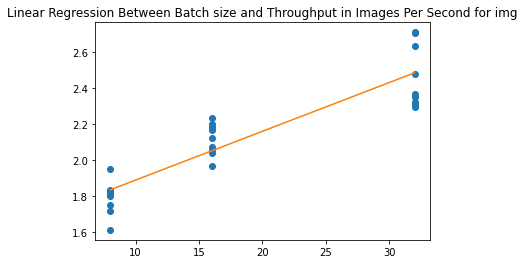

slope: 0.027188079423853866, intercept: 1.616148365308813 
correlation coefficient: 0.9064680043869855, p-value: 7.54603666824463e-11, standard error: 0.002533091671703644




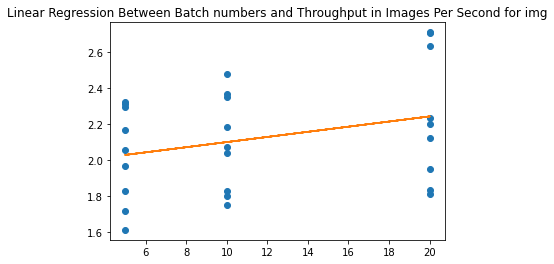

slope: 0.014316956242890876, intercept: 1.9566280250536914 
correlation coefficient: 0.29833531435018273, p-value: 0.13065989300363826, standard error: 0.00916081838986749




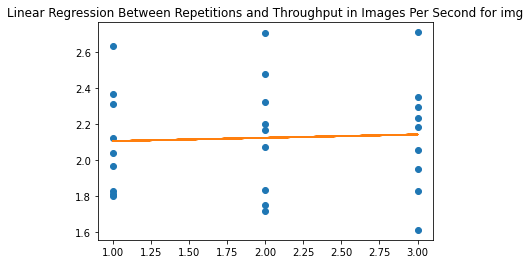

slope: 0.018456566907281185, intercept: 2.0867460474061894 
correlation coefficient: 0.050355451140527065, p-value: 0.8030270466994861, standard error: 0.07321214185299488




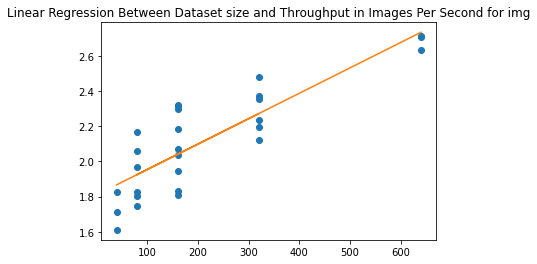

slope: 0.0014463359778621918, intercept: 1.8086793460418744 
correlation coefficient: 0.8505520583183559, p-value: 1.9291119255633556e-08, standard error: 0.0001788520439317002




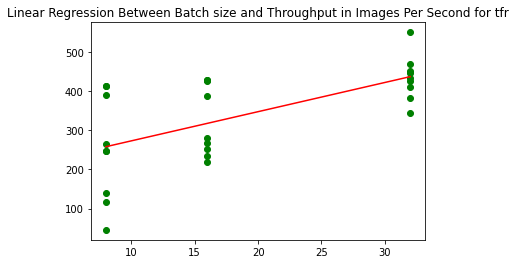

slope: 7.441726511940908, intercept: 198.2803367594535 
correlation coefficient: 0.6209066594967803, p-value: 0.0005483802651349601, standard error: 1.879011612531234




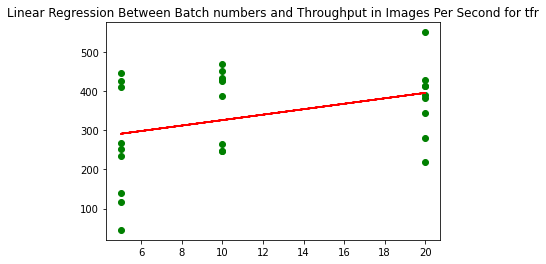

slope: 6.9461087227769225, intercept: 256.15462988328636 
correlation coefficient: 0.36222148487992506, p-value: 0.06335129706506434, standard error: 3.5748363983719695




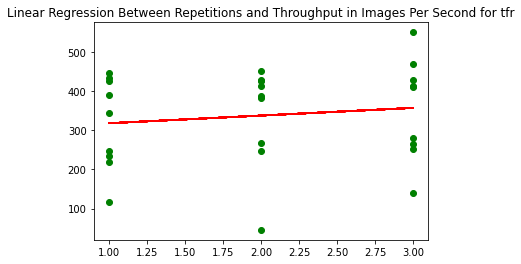

slope: 19.5882305939897, intercept: 298.0161037943711 
correlation coefficient: 0.13374250114407663, p-value: 0.5060119403593406, standard error: 29.029294425522153




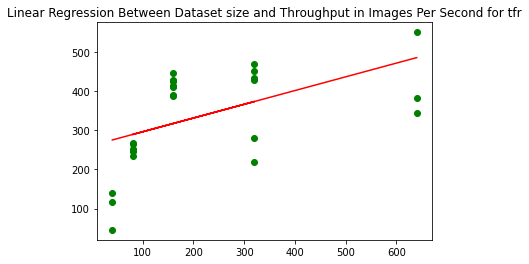

slope: 0.34982002563367826, intercept: 261.0095371776828 
correlation coefficient: 0.5148195619236055, p-value: 0.006001023913445412, standard error: 0.11650691851784546




In [ ]:
### CODING TASK ###

# using scipy.stats in order to obtain slope and intercept etc
# plotting code aided by: https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.linregress.html

def linear_regression(results_list, iv_name, dot_colour = 'tab:blue', line_colour = 'tab:orange'):

  # extracting the different variables
  filetype = results_list[0][0]
  batch_size = [x[1] for x in results_list]
  batch_numbers = [x[2] for x in results_list]
  repetitions = [x[3] for x in results_list]
  ds_size = [x*y for x,y in zip(batch_size, batch_numbers)]
  throughput = [x[4] for x in results_list]

  # assigning the iv
  if iv_name == 'batch size':
    iv = batch_size
  elif iv_name == 'batch numbers':
    iv = batch_numbers
  elif iv_name == 'repetitions':
    iv = repetitions
  elif iv_name == 'dataset size':
    iv = ds_size

  dv = throughput

  # transforming the iv and dv for regression model compatibility
  iv = np.array(iv).astype(float)
  dv = np.array(dv).astype(float)

  # intialising the linear regression
  lr = sp.stats.linregress(iv, dv)

  # ascertaining the regression result metrics
  slope, intercept, rvalue , pvalue, std_error = lr
  #print("slope: {}, intercept: {}, correlation coefficient: {}, p-value: {}, standard error: {}"\
   #     .format(slope, intercept, rvalue, pvalue, std_error))

  # plotting the regression
  plt.plot(iv, dv, 'o', label = 'data points', c = dot_colour)
  plt.plot(iv, intercept + slope * iv, label = 'regression line', c = line_colour)
  plt.title('Linear Regression Between '+iv_name.capitalize()+ ' and Throughput in Images Per Second for {}'\
            .format(filetype))
  plt.show()

  # printing the regression metrics beneath
  print("slope: {}, intercept: {} \ncorrelation coefficient: {}, p-value: {}, standard error: {}\n\n"\
        .format(slope, intercept, rvalue, pvalue, std_error))

# intialising the variables to be input in to the linear regression:


# executing the linear regressions
linear_regression(img_results, 'batch size')
linear_regression(img_results, 'batch numbers')
linear_regression(img_results,'repetitions')
linear_regression(img_results, 'dataset size')

linear_regression(tfr_results,'batch size', dot_colour = 'g', line_colour = 'r')
linear_regression(tfr_results,'batch numbers', dot_colour = 'g', line_colour = 'r')
linear_regression(tfr_results, 'repetitions', dot_colour = 'g', line_colour = 'r')
linear_regression(tfr_results, 'dataset size', dot_colour = 'g',line_colour = 'r')

## Task 2: Parallelising the speed test with Spark in the cloud. (32%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing mutliple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### Preparation: Running Spark in the cloud 

In order to test multiple configurations, especially with reasonably large datasets, we will use **Spark** to run **multiple tests in parallel**. 
We will start by looking at **how to use Spark on GCS Dataproc**. 

This section shows you in detail **how to run Python code in Dataproc**. 
You may need to **enable the Dataproc API** on the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/), if you have not done so, yet. 

First we need to **create a cluster**. We start with a single machine, just to try it out. 

We are using the `gcloud dataproc clusters` command. [Click here for documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/clusters). 
The **parameter** `--image-version 1.4-ubuntu18` makes sure we get **intended software**. 

Starting a cluster **can take a few minutes**. You can wait for the cell to finish processing or interrupt its execution and check on the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/) if the cluster is ready.


In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 1800s 

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/a37fd028-e90c-3307-bff3-2e06e4813873].
Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster] Cluster placed in zone [us-central1-f].


The `--max-idle 3600s` flag means that the cluster will be **deleted automatically** once it has been **idle for 1 hour**. This helps minimising costs for a cluster left running by accident. 

This is a single-node cluster. This is created a bit more quickly than a multi-node cluster, but set-up is still quite slow (several minutes) because of the **restrictions on the free tier**. 
You **can switch to paid tier** and still use your free credit, but then you **may use up your free credit more quickly** and have to **pay for usage**.
If you stay in the free tier Google promises not to charge you. The free tier resources are sufficient for this coursework, if you use the local Spark installation for testing and set parameters with care. All the development of this coursework was done with a free tier account. 

We have not specified the region (we could have used `--region $REGION`) as we set already the default for Dataproc in the beginning. 

You can run the **command below to get extensive information** about your running cluster. 
However, it is usually **more practical** to look at the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/). 
You can check the details and current state of your cluster by clicking on its name. 
Double-check there at the end of your working session to make sure that no clusters are left running, especially when you are not in free mode any more. 

In [ ]:
!gcloud dataproc clusters describe $CLUSTER 

clusterName: big-data-cw-310516-cluster
clusterUuid: 60924cad-5518-4040-9646-382adc30e3c3
config:
  configBucket: dataproc-staging-us-central1-95959559844-ak8xg5e8
  endpointConfig: {}
  gceClusterConfig:
    networkUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-310516/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-310516/zones/us-central1-f
  lifecycleConfig:
    idleDeleteTtl: 1800s
    idleStartTime: '2021-04-18T11:15:42.306Z'
  masterConfig:
    diskConfig:
      bootDiskSizeGb: 100
      bootDiskType

Now that our cluster is running, we can submit a Spark job. A minimal Spark job is just a Python script. A simple "Hello World" Spark script is provided in a public cloud bucket. Let's have a look at it:

In [ ]:
!gsutil cat gs://dataproc-examples/pyspark/hello-world/hello-world.py 

#!/usr/bin/python
import pyspark
sc = pyspark.SparkContext()
rdd = sc.parallelize(['Hello,', 'world!'])
words = sorted(rdd.collect())
print(words)



... and run it on the cluster. We submit the job with the `gcloud dataproc jobs` command ([click here for the documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/jobs)) with the cluster name.


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
    gs://dataproc-examples/pyspark/hello-world/hello-world.py 

Job [e5abe427b6f8485284f17f59c77e97df] submitted.
Waiting for job output...
21/04/18 11:18:49 INFO org.spark_project.jetty.util.log: Logging initialized @4372ms
21/04/18 11:18:49 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
21/04/18 11:18:49 INFO org.spark_project.jetty.server.Server: Started @4512ms
21/04/18 11:18:49 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@f2e009e{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
21/04/18 11:18:49 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.
21/04/18 11:18:50 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at big-data-cw-310516-cluster-m/10.128.0.35:8032
21/04/18 11:18:51 INFO org.apache.hadoop.yarn.clie

The `trackingUrl` shown above will only work as long as the job is running. On to the [dataproc page](https://console.cloud.google.com/dataproc/clusters/), you can click through to your cluster page and from there to your job page to see details on past jobs.

You may get some warnings like this: 
`WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair' ...
or this one:
`WARN org.apache.hadoop.hdfs.DataStreamer: Caught exception`. There was not enough time to research these fully but they don't affect what we do here and can be ignored. 

One issue is that we need to **get output data from the cluster back to the notebook**. We can output text through printing into the output stream, but that does not work well for scaling up, for automation or for binary data. 

A better solution is to **pass an argument** to the job, to tell the job on the cluster **where to write the output**. 
This requires a bit of extra code as shown below using the argparse package.
The example below the checks if the script runs in Colab and if that is the case, it does not execute the run function. 
This is useful for quick testing with a local spark instance.

For running the file in DataProc, write to a local file `hello-world.py`, uncomment the  the `%%writefile` magic as in the cell below.


In [ ]:
%%writefile hello-world.py

import sys
import pyspark
import argparse
import pickle 

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv): 
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    sc = pyspark.SparkContext.getOrCreate()
    rdd = sc.parallelize(['Hello,', 'world!'])
    words = sorted(rdd.collect())
    print(type(words))
    print(words)
    save(words,args.out_bucket,args.out_file)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    runWordCount(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    runWordCount(["--out_bucket", BUCKET, "--out_file", "words.pkl"])

Writing hello-world.py


**Once the code works as intended**, you can write it to the local disk (on your Colab instance). For this, **uncomment the first line with the `%%writefile` magic** and then **re-run the cell**. 

Then **check** that the file **is in the current directory** and **has the right contents** like this:

In [ ]:
!pwd
!ls -l hello-world.py
!cat hello-world.py

/content
-rw-r--r-- 1 root root 1442 Apr 18 11:19 hello-world.py

import sys
import pyspark
import argparse
import pickle 

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv): 
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value

We can now submit the job with an extra section for application arguments. It's started by `--`, which indicates that all following arguments are to be sent to our Spark application. 

In [ ]:
FILENAME = 'words.pkl'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./hello-world.py \
    -- --out_bucket $BUCKET --out_file $FILENAME


Job [392dd5b213494e729b305229fa4ed0b9] submitted.
Waiting for job output...
['--out_bucket', 'gs://big-data-cw-310516-storage', '--out_file', 'words.pkl']
21/04/18 11:19:21 INFO org.spark_project.jetty.util.log: Logging initialized @3309ms
21/04/18 11:19:21 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
21/04/18 11:19:21 INFO org.spark_project.jetty.server.Server: Started @3436ms
21/04/18 11:19:21 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@f2e009e{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
21/04/18 11:19:21 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.
21/04/18 11:19:23 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at big-data-cw-31051

Once the job has finished, we can **use the output** by **copying it from the bucket** and **reading it as a local file**.

In [ ]:
# Make sure you are writing to the right directory
%cd /content/drive/MyDrive/BD-CW
!gsutil cp $BUCKET/$FILENAME . 
!ls -l
with open(FILENAME,mode='rb') as f:
    words = pickle.load(f) 

print("Content of {} : {}".format(FILENAME,words))

/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-310516-storage/words.pkl...
/ [1 files][   34.0 B/   34.0 B]                                                
Operation completed over 1 objects/34.0 B.                                       
total 1
-rw------- 1 root root 34 Apr 18 11:19 words.pkl
Content of words.pkl : ['Hello,', 'world!']


At the end of a session we should **delete the cluster**, as it incurs a **cost for the time** it runs.  

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/65ce01fd-2749-3ba5-bbb2-61dbd9b36b5a].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster].


### 2a) Create the script (12%)
Your task is now to **port the speed test to Spark** for running it in the cloud in DataProc. 
**Adapt the preprocessing code** as a Spark programm that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (1%)
*   v) create an RDD with the average reading speeds for each paramter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (1%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
PROJECT = 'big-data-cw-310516' ### Append -xxxx, where xxxx is your City login ###
### it seems that the project name here has the be all lower case.
!gcloud config set project $PROJECT
REGION = 'us-central1'
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
region = us-central1
[core]
account = jakobbrown@gmail.com
project = big-data-cw-310516
[dataproc]
region = us-central1

Your active configuration is: [default]


In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://big-data-cw-310516-storage/...
ServiceException: 409 A Cloud Storage bucket named 'big-data-cw-310516-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
#!tar -xzf spark-3.0.1-bin-hadoop2.7.tgz
!tar -xzf /content/drive/MyDrive/Big_Data/data/spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()
%cd /content
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()

/root
/content
3.0.1


In [ ]:
### CODING TASK ###
## Take the timing for reading with multiple configurations in parallel with Spark

## 2Avii ##
%%writefile spark_job.py


import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
import tensorflow as tf
import pickle
import pyspark
import argparse
import datetime
from operator import add

## 2Ai ##

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'

PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)


def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label

    
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width 


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset


def save(object,bucket,filename):
  with open(filename,mode='wb') as f:
    pickle.dump(object,f)    
  print("Saving {} to {}".format(filename,bucket))
  import subprocess
  proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
  print("gstuil returned: " + str(proc.returncode))
  print(str(proc.stderr))


# EXTENSION OF PRIOR CODE STARTS HERE #
# TASK 2A #

# creating function to initialize dataset2, as done above
def initialize_img_ds(GCS_PATTTERN = 'gs://flowers-public/*/*.jpg'):
  AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API
  filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
  dataset1 = filepathDS.map(decode_jpeg_and_label)
  dataset2 = dataset1.map(resize_and_crop_image)
  return dataset2

# creating function to initalize datasetDecoded, as done above
def initialize_tfr_ds():
  GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  datasetDecoded = load_dataset(filenames)
  return datasetDecoded

## Speed Test Section (adapted for task 2 input and goal) ##
def time_configs(param_list):

  [ft, bs, bn, rep] = param_list

  # intialising list, which will be filled iteratively with the different combinations of parameters
  # along with their corresponding results in terms of throughput
  result = [] 

  if ft == 'img':
    ds = initialize_img_ds()

    # batching the data set
    data_batched = ds.batch(bs)

    # taking a batch from the batched data set
    batch = data_batched.take(bn)

    # starting timer
    throughput_timer = time.time()
    
    # iterating over data set
    for image, label in batch:
      # going through each image and retrieving basic information, printing to the null device
      print("image batch shape {}, {}".format(image.numpy().shape, [str(lbl) for lbl in label.numpy()]), \
                                                  file=open("/dev/null",mode='w'))
          
    # taking the time measurement
    throughput_result = time.time() - throughput_timer

    # calculating throughput per second
    tps = ((bs * bn)/ throughput_result)
  
    result.append([[ft, bs, bn, rep, bs*bn], tps])
    
    return result
  
  elif ft == 'tfr':
    ds = initialize_tfr_ds()

    # batching the data set
    data_batched = ds.batch(bs)

    # taking a batch from the batched data set
    batch = data_batched.take(bn)

    # starting timer
    throughput_timer = time.time()
    
    # iterating over data set
    for image, label in batch:
      # going through each image and retrieving basic information, printing to the null device
      print("image batch shape {}, {}".format(image.numpy().shape, [str(lbl) for lbl in label.numpy()]), \
                                                  file=open("/dev/null",mode='w'))
          
    # taking the time measurement     
    throughput_result = time.time() - throughput_timer

    # calculating throughput per second
    tps = ((bs * bn)/ throughput_result)

    result.append([[ft, bs, bn, rep, bs*bn], tps])
    
    return result
  

# function to aid in Task 2Aiv
def combo2individualparams(x):

  output = []

  [ft, bs, bn, rep, ds] = x[0][0]
  tps = x[0][1]
  
  output.append((ft+': '+'batch_size: '+str(bs), tps))
  output.append((ft+': '+'batch_number: '+str(bn), tps))
  output.append((ft+': '+'repetition: '+str(rep), tps))
  output.append((ft+': '+'data_size: '+str(ds), tps))

  return output


def task2a(argv):
  # Parse the provided arguments
  print(argv)
  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                      help='The bucket URL for the result.') # add a required argument
  parser.add_argument('--out_file', metavar='out_file', required=True,
                     help='The filename for the result.') # add a required argument
  args = parser.parse_args(argv) # read the value

  # initialising params list
  params = []
  
  # intialising parameters to iterate over
  batch_sizes = [5, 10, 20, 40, 80] 
  batch_numbers = [5, 10, 15, 20] 
  repetitions = [1,2,3]
  
  #batch_sizes = [5, 2]
  #batch_numbers = [3, 4]
  #repetitions = [11, 13]

  # iterating over parameters
  for batch_size in batch_sizes:
    for batch_number in batch_numbers:
      for rep in repetitions:
        # adding both img and tfr version of each parameter combination
        params.append(['tfr', batch_size, batch_number, rep])
        params.append(['img', batch_size, batch_number, rep])

  print("params initialised")

  ## 2aii ##    
  # creating spark context
  sc = pyspark.SparkContext.getOrCreate()
  print(sc)

  print("spark context created")
  print("starting timer for overall job")
  overall_t = time.time()

  # parallelizing parameter combinations
  ## TASK 2Cii ##
  params_rdd = sc.parallelize(params, len(params))
  #params_rdd = sc.parallelize(params)

  print("params rdd parallelized")

    ## 2Aiii ##
  params_tps_rdd = params_rdd.map(lambda x: time_configs(x))

  print("params rdd mapped to timing function")

  ## TASK 2Ci ##
  params_tps_rdd.cache()
  print("params_tps_rdd cached")

  ## 2Aiv ##
  param_tps_rdd = params_tps_rdd.flatMap(lambda x: combo2individualparams(x))

  print("flatMap to individual params with tps completed")

  ## TASK 2Ci ##
  param_tps_rdd.cache()
  print("param_tps_rdd cached")

  ## 2Av ##
  # solution aided by code from big data lab 3

  # Pairing each param with a 1: (param, 1)
  denom_rdd = param_tps_rdd.map(lambda x: (x[0], 1))
  # reducing by key, adding all of the 1s
  denom_rdd = denom_rdd.reduceByKey(add)

  # adding all of the throughput values by key
  nom_rdd = param_tps_rdd.reduceByKey(add)

  #joining the two RDDs
  dividing_rdd = nom_rdd.join(denom_rdd)
  
  # dividing the sum of the throughputs values by the number of values per param
  param_avs_rdd = dividing_rdd.map(lambda x: (x[0], x[1][0]/x[1][1]))

  ## TASK 2Ci ##
  param_avs_rdd.cache()
  print("param_avs_rdd cached")

  for each in param_avs_rdd.take(3):
    print(each)
  print('\n\n\n')

  # collecting results
  print("collecting results")
  
  param_results = param_tps_rdd.collect()
  print("first one collected")
  param_avs = param_avs_rdd.collect()
  print("second one collected")

  print(param_results)
  print(len(param_results))
  print(param_avs)
  print(len(param_avs))

  print("results collected")

  print("total time for the whole job: {}".format(time.time()-overall_t))

  ## 2Avi ##
  save([param_results, param_avs], args.out_bucket, args.out_file)

# change to true when using caching and appropriate parallelization to change title of file accordingly
with_efficiency_changes = True

if with_efficiency_changes:
  FILENAME = str(datetime.datetime.now().strftime("%y%m%d-%H%M"))+'_post_2C.pkl'
else:
  FILENAME = str(datetime.datetime.now().strftime("%y%m%d-%H%M"))+'.pkl'

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task2a(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    task2a(["--out_bucket", BUCKET, "--out_file", FILENAME])


Overwriting spark_job.py


### 2b) Set up a cluster and run the script. (4%)

In the free credit tier on Google Cloud, there are the following **restrictions**:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persisten disk* 
- max 8 *vCPU*s

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The disks are virtual disks, where the I/O speed is limited in proportion to the size, so that we should allocated them evenly.
This has mainly an effect on the time the cluster needs to start, as we are reading the data mainly from the bucket and we are not writing much to disk at all.   

The largest possible cluster within these constraints has 1 master and 7 worker nodes. 
Each of them with 1 (virtual) CPU. The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

In order to run our code on the cluster, we need to **make sure** that **TensorFlow 2 is installed**. The Colab magic  `%tensorflow_version 2.x` will not work within Spark. 
Instead, enable package installation by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
The packages are then specified by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.1.0`. 
(2%)

In [ ]:
### CODING TASK ###

PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)

REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh\
    --metadata PIP_PACKAGES=tensorflow==2.1.0 \
    --max-idle 1800s

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/9340c0fa-79f7-36b6-8646-37314c9f38d2].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
!gcloud dataproc clusters describe $CLUSTER

clusterName: big-data-cw-310516-cluster
clusterUuid: ca8ab0ac-838d-4e9b-a16c-abb3f72becbb
config:
  configBucket: dataproc-staging-us-central1-95959559844-ak8xg5e8
  endpointConfig: {}
  gceClusterConfig:
    metadata:
      PIP_PACKAGES: tensorflow==2.1.0
    networkUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-310516/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-310516/zones/us-central1-f
  initializationActions:
  - executableFile: gs://goog-dataproc-initialization-actions-us-central1/python/pip-inst

In [ ]:
!pwd
!ls -l spark_job.py
!cat spark_job.py

/content
-rw-r--r-- 1 root root 10006 Apr 19 13:12 spark_job.py


import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
import tensorflow as tf
import pickle
import pyspark
import argparse
import datetime
from operator import add

## 2Ai ##

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'

PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)


def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


def resize_and_crop_image(image, label):
  # Resize and

Once the cluster is running, you can run the job. It is useful to create a new filename, so that results don't get overwritten. 

You can for instance use `str(datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

While you run this job, switch to the DataProc web page and take images of the CPU and Network load over time. 
Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs. These will be needed in the next task. 
(2%)

In [ ]:
### CODING TASK ###

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_job.py \
    -- --out_bucket $BUCKET --out_file $FILENAME 

Job [f6b4621d2ddb42478cc8a021d86eff67] submitted.
Waiting for job output...
2021-04-19 13:18:55.063755: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-19 13:18:55.064458: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-19 13:18:55.064521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
['--out_bucket', 'gs://big-data-cw-310516-storage', '--out_file', 'test.pkl']
params initialised
21/04/19 13:18:5

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/73a6ec39-8f64-33ea-80c3-55476f82806d].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster].


### 2c) Improve cluster efficiency (6%)

If you implemented a straightfoward version, you will probably have some inefficiencies in your code. 
There are two main aspects: 
- Caching 
- Parallelisation branches

i) Because we are reading multiple times from the RDD to read the valudes for the different parameters and their averages, caching existing results is important. Explain where in the process caching can help, and add it to your code, if you haven't yet. Measure the the effect of using caching or not using it.

ii) You will probably observe that all the computation is done on only two branches, if you do the straightforward implementation. This can be adressed by using the second parameter in the initial call parallelize. 

Write make the suitable changes in the code you have written above and mark them up in comments as `### TASK 2Ci ###` and  `### TASK 2cii ###`. 

Explain in your report what the reasons for these changes are and demonstrate and interpret their effects.

### 2d) Retrieve, analyse and discuss the output (10%)


Implement a linear regression over each parameter for the two cases (reading from image files/reading TFRecord files. 
List a table with the output and interpret the results in terms of the effects of overall.  
Also, plot the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the implications of this result for large-scale machine learning. Keep in mind that cloud data may be stored in distant physical locations. Use the numbers provided in the PDF latency-numbers provided on Moodle or available [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the observed behaviour similar or different from what you’d expect from a single machine? Why would cloud providers tie throughput to capacity of disk resources? 

By parallelising the speed test we are making assumptions about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, what we need to consider in running tests in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent linear modelling reflects the effects we are observing. Discuss what could expected from a theoretical perspective and what can be useful in practice.
  

Write your code below and include the output in your submission. Provide the answer text in your report. 

Copying gs://big-data-cw-310516-storage/210419-1145_post_2C.pkl...
/ [1 files][ 22.0 KiB/ 22.0 KiB]                                                
Operation completed over 1 objects/22.0 KiB.                                     
[('tfr: batch_size: 5', 113.47684742285), ('tfr: batch_number: 5', 113.47684742285), ('tfr: repetition: 1', 113.47684742285), ('tfr: data_size: 25', 113.47684742285), ('img: batch_size: 5', 7.071863744470976), ('img: batch_number: 5', 7.071863744470976), ('img: repetition: 1', 7.071863744470976), ('img: data_size: 25', 7.071863744470976), ('tfr: batch_size: 5', 87.0707085804725), ('tfr: batch_number: 5', 87.0707085804725), ('tfr: repetition: 2', 87.0707085804725), ('tfr: data_size: 25', 87.0707085804725), ('img: batch_size: 5', 7.904336493934191), ('img: batch_number: 5', 7.904336493934191), ('img: repetition: 2', 7.904336493934191), ('img: data_size: 25', 7.904336493934191), ('tfr: batch_size: 5', 119.42670226239396), ('tfr: batch_number: 5', 119.426702262393

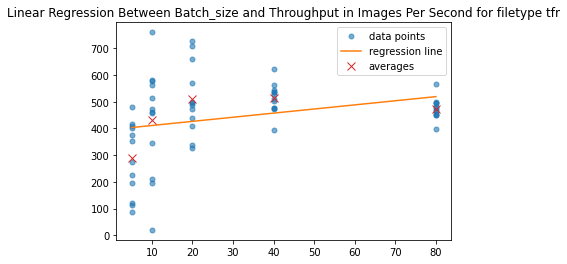

slope: 1.5418202330845832, intercept: 395.5519937308905 
correlation coefficient: 0.28238032486500103, p-value: 0.028815896838148912, standard error: 0.687766315959872




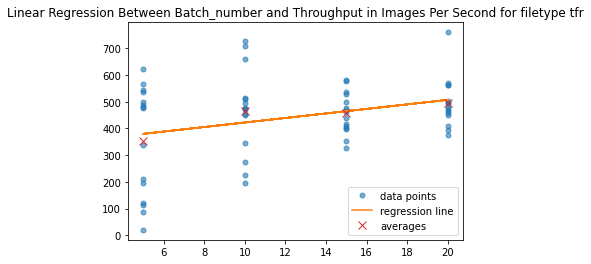

slope: 8.467433673966758, intercept: 337.50550003192814 
correlation coefficient: 0.31782718364138385, p-value: 0.013337674224708981, standard error: 3.316829922789405




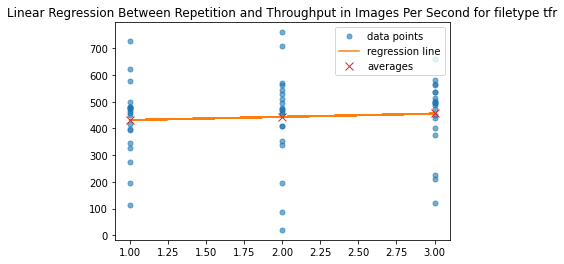

slope: 12.03518681975156, intercept: 419.27804731700945 
correlation coefficient: 0.06598138565589025, p-value: 0.6164522527120324, standard error: 23.898463719958325




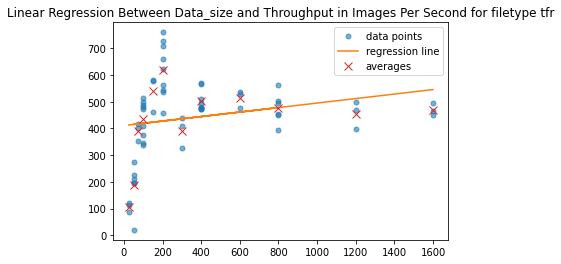

slope: 0.08415905924844906, intercept: 410.7367854977386 
correlation coefficient: 0.23266978015071232, p-value: 0.0736179757786015, standard error: 0.04619143151568523




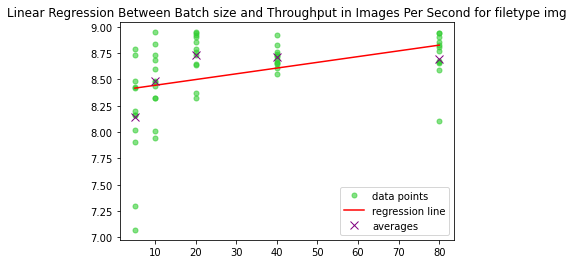

slope: 0.00544216960962223, intercept: 8.390301740236012 
correlation coefficient: 0.3981802373212367, p-value: 0.0016281915239423346, standard error: 0.0016462401031251846




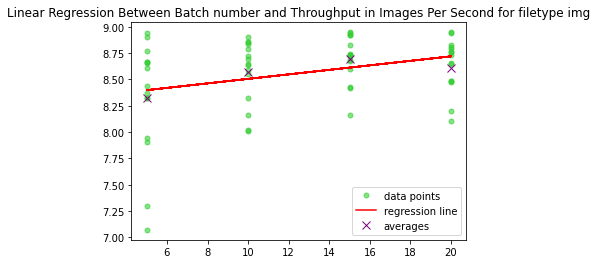

slope: 0.021397265024453112, intercept: 8.291543185328637 
correlation coefficient: 0.32085176835453333, p-value: 0.012437056881525932, standard error: 0.00829371600195768




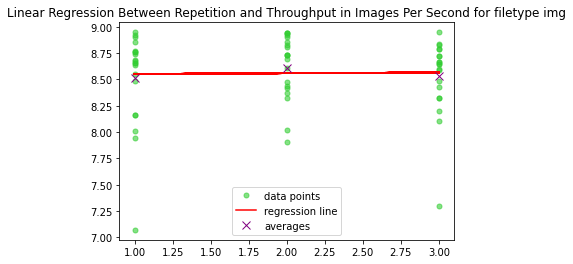

slope: 0.007081239498497128, intercept: 8.544846519137307 
correlation coefficient: 0.015509036360178075, p-value: 0.9063747819177231, standard error: 0.059945727541262255




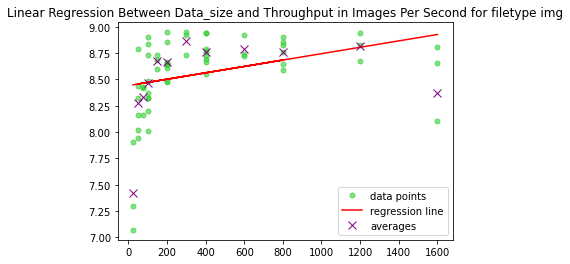

slope: 0.0003032268312115211, intercept: 8.441508601039837 
correlation coefficient: 0.3348988607060752, p-value: 0.008908474946640708, standard error: 0.00011202320343275584




In [ ]:
### CODING TASK ### 
FILENAME = '210419-1145_post_2C.pkl'

PATH = BUCKET+'/'+FILENAME
!gsutil cp $PATH .

with open(FILENAME, mode = 'rb') as f:
  [param_results, param_avs] = pickle.load(f)

print(param_results)
print(param_avs)

# slicing the data to get all in the correct groups
tfr_batch_sizes = []
tfr_batch_numbers = []
tfr_repetitions = []
tfr_data_sizes = []

img_batch_sizes = []
img_batch_numbers = []
img_repetitions = []
img_data_sizes = []

# re-arranging the RDD data to desired format
tfr_data = [(x[0].split('tfr: ')[1], x[1]) for x in param_results if 'tfr' in x[0]]
tfr_data = [{x[0].split(': ')[0]: (int(x[0].split(': ')[1]), x[1])} for x in tfr_data]

img_data = [(x[0].split('img: ')[1], x[1]) for x in param_results if 'img' in x[0]]
img_data = [{x[0].split(': ')[0]: (int(x[0].split(': ')[1]), x[1])} for x in img_data]

tfr_avs = [(x[0].split('tfr: ')[1], x[1]) for x in param_avs if 'tfr' in x[0]]
tfr_avs = [{x[0].split(': ')[0]: (int(x[0].split(': ')[1]), x[1])} for x in tfr_avs]

img_avs = [(x[0].split('img: ')[1], x[1]) for x in param_avs if 'img' in x[0]]
img_avs = [{x[0].split(': ')[0]: (int(x[0].split(': ')[1]), x[1])} for x in img_avs]

# reading the data from the RDDs to lists
for i in range(len(tfr_data)):
  for key in tfr_data[i]:
    if key == 'batch_size':
      tfr_batch_sizes.append(tfr_data[i][key])
    elif key == 'batch_number':
      tfr_batch_numbers.append(tfr_data[i][key])
    elif key == 'repetition':
      tfr_repetitions.append(tfr_data[i][key])
    else:
      tfr_data_sizes.append(tfr_data[i][key])

for i in range(len(img_data)):
  for key in img_data[i]:
    if key == 'batch_size':
      img_batch_sizes.append(img_data[i][key])
    elif key == 'batch_number':
      img_batch_numbers.append(img_data[i][key])
    elif key == 'repetition':
      img_repetitions.append(img_data[i][key])
    else:
      img_data_sizes.append(img_data[i][key])

# getting average values
  tfr_batch_size_avs = []
  tfr_batch_number_avs = []
  tfr_repetition_avs = []
  tfr_data_size_avs = []

  img_batch_size_avs = []
  img_batch_number_avs = []
  img_repetition_avs = []
  img_data_size_avs = []

  for i in range(len(tfr_avs)):
    for key in tfr_avs[i]:
      if key == 'batch_size':
        tfr_batch_size_avs.append(tfr_avs[i][key])
      elif key == 'batch_number':
        tfr_batch_number_avs.append(tfr_avs[i][key])
      elif key == 'repetition':
        tfr_repetition_avs.append(tfr_avs[i][key])
      else:
        tfr_data_size_avs.append(tfr_avs[i][key])
  
  for i in range(len(img_avs)):
    for key in img_avs[i]:
      if key == 'batch_size':
        img_batch_size_avs.append(img_avs[i][key])
      elif key == 'batch_number':
        img_batch_number_avs.append(img_avs[i][key])
      elif key == 'repetition':
        img_repetition_avs.append(img_avs[i][key])
      else:
        img_data_size_avs.append(img_avs[i][key])


# defining the linear regression function (adapted)

def linear_regression(data, av_data, iv_name, filetype, dot_colour = 'tab:blue', line_colour = 'tab:orange'):

  iv = np.array([x[0] for x in data]).astype(float)
  dv = np.array([x[1] for x in data]).astype(float)

  av_iv = np.array([x[0] for x in av_data]).astype(float)
  av_dv = np.array([x[1] for x in av_data]).astype(float)

  # intialising the linear regression
  lr = sp.stats.linregress(data)

  # ascertaining the regression result metrics
  slope, intercept, rvalue , pvalue, std_error = lr

  # plotting the regression
  if filetype == 'tfr':

    plt.plot(iv, dv, 'o', label = 'data points', c = 'tab:blue', alpha = 0.6, markersize = 5)
    plt.plot(iv, intercept + slope * iv, label = 'regression line', c = 'tab:orange')
    plt.plot(av_iv, av_dv, 'x', label = 'averages', c = 'tab:red', markersize = 8)
    plt.title('Linear Regression Between '+iv_name.capitalize()+ ' and Throughput in Images Per Second for filetype {}'\
              .format(filetype))
    plt.legend()
    plt.show()
  
  else:
    plt.plot(iv, dv, 'o', label = 'data points', c = 'limegreen', alpha = 0.6, markersize = 5)
    plt.plot(iv, intercept + slope * iv, label = 'regression line', c = 'r')
    plt.plot(av_iv, av_dv, 'x', label = 'averages', c = 'purple', markersize = 8)
    plt.title('Linear Regression Between '+iv_name.capitalize()+' and Throughput in Images Per Second for filetype {}'\
              .format(filetype))
    plt.legend()
    plt.show()

  # printing the regression metrics beneath
  print("slope: {}, intercept: {} \ncorrelation coefficient: {}, p-value: {}, standard error: {}\n\n"\
        .format(slope, intercept, rvalue, pvalue, std_error))

# executing the linear regressions
linear_regression(tfr_batch_sizes, tfr_batch_size_avs, 'batch_size', 'tfr')
linear_regression(tfr_batch_numbers, tfr_batch_number_avs, 'batch_number', 'tfr')
linear_regression(tfr_repetitions, tfr_repetition_avs, 'repetition', 'tfr')
linear_regression(tfr_data_sizes, tfr_data_size_avs, 'data_size', 'tfr')

linear_regression(img_batch_sizes, img_batch_size_avs, 'batch size', 'img')
linear_regression(img_batch_numbers, img_batch_number_avs, 'batch number', 'img')
linear_regression(img_repetitions, img_repetition_avs, 'repetition', 'img')
linear_regression(img_data_sizes, img_data_size_avs, 'data_size', 'img')

In [ ]:
# making table of average findings
import pandas as pd

print(tfr_batch_size_avs)

df = pd.DataFrame(columns = ['filetype', 'parameter', 'value','IPS (avg)'])

for each in tfr_avs:
  for key, value in each.items():
    df = df.append({'filetype': 'tfr', 'parameter': key, 'value': value[0], 'IPS (avg)': round(value[1], 2)}, ignore_index = True)

for each in img_avs:
  for key, value in each.items():
    df = df.append({'filetype': 'img', 'parameter': key, 'value': value[0], 'IPS (avg)': round(value[1], 2)}, ignore_index = True)

df = df.sort_values(by = ['parameter','value', 'filetype'], ascending=(False, True, False))
df



[(80, 474.4198570827122), (10, 429.890789273553), (5, 287.9099538218135), (20, 510.91649486534214), (40, 513.6050097391422)]


filetype     parameter value  IPS (avg)
16      tfr    repetition     1     432.43
37      img    repetition     1       8.52
7       tfr    repetition     2     441.12
36      img    repetition     2       8.60
15      tfr    repetition     3     456.50
41      img    repetition     3       8.53
11      tfr     data_size    25     106.66
32      img     data_size    25       7.43
23      tfr     data_size    50     187.04
43      img     data_size    50       8.28
14      tfr     data_size    75     390.40
25      img     data_size    75       8.34
3       tfr     data_size   100     435.95
46      img     data_size   100       8.46
8       tfr     data_size   150     540.90
34      img     data_size   150       8.67
17      tfr     data_size   200     620.04
27      img     data_size   200       8.66
13      tfr     data_size   300     390.43
44      img     data_size   300       8.87
20      tfr     data_size   400     502.42
38      img     data_size   400       8.76
1       tfr     data_size   600     513.96
26      img     data_size   600       8.79
19      tfr     data_size   800     475.19
31      img     data_size   800       8.76
12      tfr     data_size  1200     454.69
47      img     data_size  1200       8.82
0       tfr     data_size  1600     470.23
24      img     data_size  1600       8.37
6       tfr    batch_size     5     287.91
33      img    batch_size     5       8.14
5       tfr    batch_size    10     429.89
39      img    batch_size    10       8.48
9       tfr    batch_size    20     510.92
28      img    batch_size    20       8.73
10      tfr    batch_size    40     513.61
30      img    batch_size    40       8.71
4       tfr    batch_size    80     474.42
45      img    batch_size    80       8.69
18      tfr  batch_number     5     353.35
29      img  batch_number     5       8.32
22      tfr  batch_number    10     465.14
35      img  batch_number    10       8.57
21      tfr  batch_number    15     458.08
40      img  batch_number    15       8.70
2       tfr  batch_number    20     496.83
42      img  batch_number    20       8.61

In [ ]:
for each in tfr_avs:
  for key, value in each.items():
    print(key)
    print(value)

data_size
(1600, 470.23456750698483)
data_size
(600, 513.9576058814574)
batch_number
(20, 496.8271019192356)
data_size
(100, 435.9496074397991)
batch_size
(80, 474.4198570827122)
batch_size
(10, 429.890789273553)
batch_size
(5, 287.9099538218135)
repetition
(2, 441.1182088692802)
data_size
(150, 540.903103940626)
batch_size
(20, 510.91649486534214)
batch_size
(40, 513.6050097391422)
data_size
(25, 106.65808608857215)
data_size
(1200, 454.685135385984)
data_size
(300, 390.4309198608071)
data_size
(75, 390.40238940066615)
repetition
(3, 456.49871381988044)
repetition
(1, 432.4283401803774)
data_size
(200, 620.0408347071668)
batch_number
(5, 353.3473509701852)
data_size
(800, 475.1878645919312)
data_size
(400, 502.4202110400616)
batch_number
(15, 458.0758308939082)
batch_number
(10, 465.14340004272157)
data_size
(50, 187.04446116010476)


In [ ]:
print(tfr_avs)

[{'data_size': (1600, 470.23456750698483)}, {'data_size': (600, 513.9576058814574)}, {'batch_number': (20, 496.8271019192356)}, {'data_size': (100, 435.9496074397991)}, {'batch_size': (80, 474.4198570827122)}, {'batch_size': (10, 429.890789273553)}, {'batch_size': (5, 287.9099538218135)}, {'repetition': (2, 441.1182088692802)}, {'data_size': (150, 540.903103940626)}, {'batch_size': (20, 510.91649486534214)}, {'batch_size': (40, 513.6050097391422)}, {'data_size': (25, 106.65808608857215)}, {'data_size': (1200, 454.685135385984)}, {'data_size': (300, 390.4309198608071)}, {'data_size': (75, 390.40238940066615)}, {'repetition': (3, 456.49871381988044)}, {'repetition': (1, 432.4283401803774)}, {'data_size': (200, 620.0408347071668)}, {'batch_number': (5, 353.3473509701852)}, {'data_size': (800, 475.1878645919312)}, {'data_size': (400, 502.4202110400616)}, {'batch_number': (15, 458.0758308939082)}, {'batch_number': (10, 465.14340004272157)}, {'data_size': (50, 187.04446116010476)}]


## Task 3: Write TFRecord files to the cloud with Spark (20%)

This task of pre-processing images and creating TFRecord files is a more straightforward case of parallelisation. We will again use Spark.

### 3a)	Create the script (10%)

Re-Implement the code for creating the TFRecord files in Spark, using Spark mechanisms for distributing the workload over the shards. 

You need to copy over the mapping functions and adapt the resizing and recompression function to Spark (onyl one argument). (2%)
Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames. (2%)
Then use the mapping functions like with the TensorFlow Dataset object. (2%)

The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. The return value of that function is not essential. You can return the filename, so that you have a list of the created TFRecord files. (4%) 



In [ ]:
### CODING TASK ###
## Write the images to TFRecord files with Spark

%%writefile spark_job_task3.py


import os, sys, math
import numpy as np
import tensorflow as tf
import time
import pyspark
import argparse

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

TARGET_SIZE = [192, 192]
SHARDS = 16 # shards are partitiones into shards
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'


PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_OUTPUT = BUCKET +'/tfrecords-jpeg-192x192-2/flowers'


# bringing together all necessary functions and adapting them in order to 
# write image files to bucket via spark

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


def resize_and_crop_image(one_arg):
  image, label = one_arg
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label

    
def recompress_image(one_arg):
  image, label = one_arg
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return [image, label, height, width] # <-- returning all info regarding the image in one item

# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]) #,        # one class in the list
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

## function which replaces Dataset objects with RDD of filenames ##
def writeTFRecords(idx, iterator):
  filename = GCS_OUTPUT + "{:02d}.tfrec".format(idx)
  #filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(idx)
  with tf.io.TFRecordWriter(filename) as out_file:
    for (image, label, height, width) in iterator:
      example = to_tfrecord(out_file,
                            image.numpy(), # re-compressed image: already a byte string
                            label.numpy() #, height.numpy()[i], width.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
  return [filename]

# defining the workflow function for task 3
def task3a():

  print("Writing TFRecords")

  t0 = time.time()

  sc = pyspark.SparkContext.getOrCreate()

  # sharding/partitioning
  filenames = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
  #filenames = tf.io.gfile.glob(GCS_PATTERN)
  rdd1 = sc.parallelize(filenames, SHARDS)
  #rdd1 = rdd1.sample(False, 0.1) # <- commented out when writing TFRecord files to the cloud

  print("shards: {} \nRDD count: {}".format(SHARDS, rdd1.count()))

  # transforming the image files
  decoded_and_labelled_rdd = rdd1.map(decode_jpeg_and_label)
  print('decoded and labelled example: {}'.format(decoded_and_labelled_rdd.first()))

  resized_cropped_rdd = decoded_and_labelled_rdd.map(resize_and_crop_image)
  print('resized and cropped example: {}'.format(resized_cropped_rdd.first()))

  recompressed_rdd = resized_cropped_rdd.map(recompress_image)

  # ascertaining the number of partitions
  num_partitions = recompressed_rdd.getNumPartitions()
  print("number of partitions: {}".format(num_partitions))

  # Writing the TfRecords 
  final_rdd = recompressed_rdd.mapPartitionsWithIndex(writeTFRecords)
  print("final rdd: "+str(final_rdd.collect()))
  
  
  print('time taken for whole job: {}'.format(time.time() - t0))


task3a()

Writing spark_job_task3.py


### 3b)	Run and test (2%)

Run the script and test the output. Demonstrate that the files you wrote with your spark job work can be read and used by the model training. 

In [ ]:
### CODING TASK ###

# creating cluster
PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)

REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh\
    --metadata PIP_PACKAGES=tensorflow==2.1.0 \
    --max-idle 1800s

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/d3adbe86-8a7d-307b-8aae-be2eac4b883e].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
# submitting spark job

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION\
  ./spark_job_task3.py

Job [11debcfda2fc49199159ad7d39333e1c] submitted.
Waiting for job output...
2021-04-21 15:41:03.843299: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-21 15:41:03.843579: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-21 15:41:03.843617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Writing TFRecords
21/04/21 15:41:07 INFO org.spark_project.jetty.util.log: Logging initialized @8438ms
21/04/21 1

In [ ]:
# deleting the cluster
!gcloud dataproc clusters delete $CLUSTER -q 

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/ec392290-05c7-3bcd-b3e6-d823b0e47ce3].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster].


Read from the TFRecord Dataset to test. 


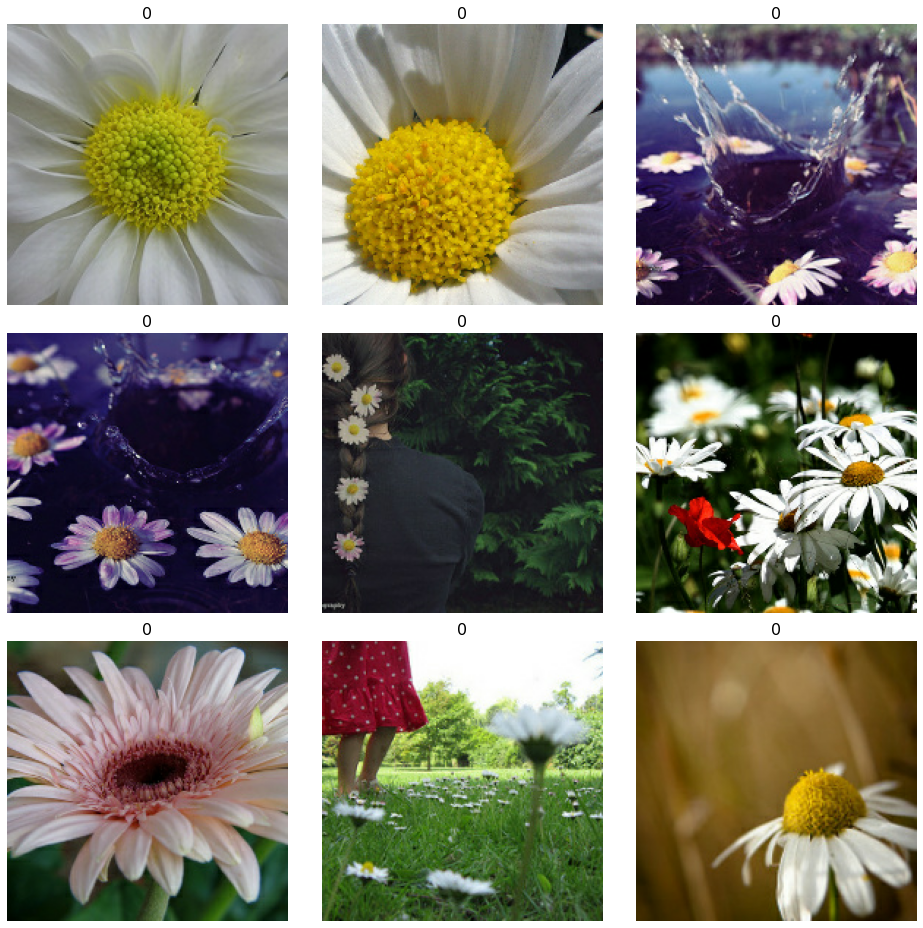

In [ ]:
### CODING TASK ###


TARGET_SIZE = [192, 192]
SHARDS = 16 # shards are partitiones into shards
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'

PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_OUTPUT = BUCKET +'/tfrecords-jpeg-192x192-2/flowers'

# defining necessary functions for visualisation
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset


def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

# reading from the created data set in bucket
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetDecoded = load_dataset(filenames)

display_9_images_from_dataset(datasetDecoded)

### 3c)	Experiment and discussion (8%)

i) Explain the difference between this use of Spark and most standard applications like e.g. in our labs. (2%)

ii)	Test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with 8-fold resources (8 vCPUs). Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

Write your answers in your report.

In [ ]:
## 1 master with 2vCPUs and 3 workers with 2vCPUs each ##
PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)

REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3 --worker-machine-type n1-standard-2 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh\
    --metadata PIP_PACKAGES=tensorflow==2.1.0 \
    --max-idle 1800s

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/99464210-d9da-3ba2-8456-7928a5aa921a].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION\
  ./spark_job_task3.py

Job [39c096f0ea7c4ac7a288b6353895feba] submitted.
Waiting for job output...
2021-04-20 12:27:41.831088: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-20 12:27:41.831261: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-20 12:27:41.831278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Writing TFRecords
21/04/20 12:27:44 INFO org.spark_project.jetty.util.log: Logging initialized @6275ms
21/04/20 1

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/f7076720-4ccb-369e-8222-bbbbd1769b73].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster].


In [ ]:
# 1 machine with 8-fold resources (8 vCPUs)

PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)

REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh\
    --metadata PIP_PACKAGES=tensorflow==2.1.0 \
    --max-idle 1800s

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/b8ce642e-4b31-3165-9acc-fc47ca6812e1].
Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION\
  ./spark_job_task3.py

Job [6eeb1c059d37402ca3c64dfded69cbfe] submitted.
Waiting for job output...
2021-04-20 13:00:41.229879: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-20 13:00:41.230029: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-20 13:00:41.230039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Writing TFRecords
21/04/20 13:00:43 INFO org.spark_project.jetty.util.log: Logging initialized @5845ms
21/04/20 1

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-310516/regions/us-central1/operations/10b0c640-1485-36b9-a435-3399953d72c8].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-310516/regions/us-central1/clusters/big-data-cw-310516-cluster].


# Section 2: Machine Learning in the Cloud

In this section we will use the pre-processed data with the GC AI-Platform for Machine Learning. 

## Preparation: Machine Learning Setup

As in Section 1, In this section, we get started based on  code from the 'Fast and Lean Data Science' course, this time lecture 4, to establish the task.


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


### Create Train and Test Sets 

We will first set up a few variables for the machine learning and then run split the test and training sets. 

In [ ]:
BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # this value is for testing. Increase later 
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
#GCS_TFR_PATTERN = 'gs://bd-cw-2-bucket/tfrecords-jpeg-192x192-2/flowers*.tfrec' 

TARGET_SIZE = [192,192]

VALIDATION_SPLIT = 0.25

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings

SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets


In [ ]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))


len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 12 training files and 4 validation files
With a batch size of 64, there will be 42 batches per training epoch and 14 batch(es) per validation run.


In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 


def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset


# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [ ]:
sample_set = training_dataset.take(4)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (64, 192, 192, 3), ['1', '0', '0', '3', '3', '0', '0', '2', '2', '4', '1', '4', '4', '3', '3', '0', '1', '2', '4', '1', '2', '3', '2', '2', '1', '0', '4', '2', '0', '0', '1', '4', '4', '1', '4', '0', '1', '3', '1', '1', '0', '0', '0', '1', '4', '0', '3', '0', '2', '3', '4', '1', '2', '2', '1', '2', '2', '4', '4', '0', '0', '3', '4', '2'])
Image batch shape (64, 192, 192, 3), ['3', '1', '1', '0', '3', '3', '1', '2', '2', '3', '1', '4', '0', '0', '1', '2', '1', '0', '4', '3', '1', '4', '4', '2', '1', '0', '4', '3', '4', '2', '0', '1', '4', '0', '2', '4', '0', '0', '1', '2', '0', '2', '1', '4', '0', '4', '1', '3', '1', '1', '1', '0', '1', '3', '4', '2', '2', '2', '4', '1', '2', '0', '3', '2'])
Image batch shape (64, 192, 192, 3), ['1', '3', '4', '4', '2', '2', '0', '2', '0', '2', '0', '1', '1', '1', '0', '1', '4', '1', '1', '2', '4', '0', '0', '1', '4', '0', '1', '1', '4', '1', '1', '2', '1', '3', '3', '4', '2', '0', '3', '4', '0', '0', '3', '2', '2', '4', '0', '1', '2',

### Set up a pretrained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 46080)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               4608100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 6,866,589
Trainable params: 4,608,605
Non-trainable params: 2,257,984
_________________________________________________________________


### Local Training

In [ ]:
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0
print("Wall clock time = {}".format(tt))

Epoch 1/5
42/42 [==============================] - 85s 2s/step - loss: 4.8785 - accuracy: 0.2358 - val_loss: 1.5668 - val_accuracy: 0.2790
Epoch 2/5
42/42 [==============================] - 78s 2s/step - loss: 1.5726 - accuracy: 0.2884 - val_loss: 1.5197 - val_accuracy: 0.2768
Epoch 3/5
42/42 [==============================] - 77s 2s/step - loss: 1.5255 - accuracy: 0.2875 - val_loss: 1.5147 - val_accuracy: 0.3315
Epoch 4/5
42/42 [==============================] - 78s 2s/step - loss: 1.4753 - accuracy: 0.2877 - val_loss: 1.4590 - val_accuracy: 0.4051
Epoch 5/5
42/42 [==============================] - 78s 2s/step - loss: 1.4526 - accuracy: 0.3119 - val_loss: 1.4467 - val_accuracy: 0.4051
Wall clock time = 395.68620443344116


Result: Training time

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


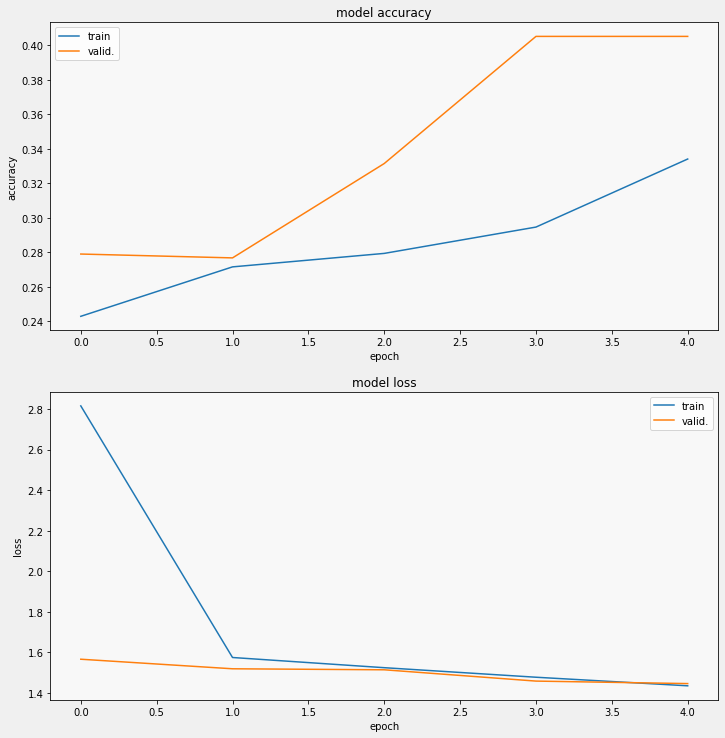

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

['tulips', 'tulips', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'tulips', 'tulips']


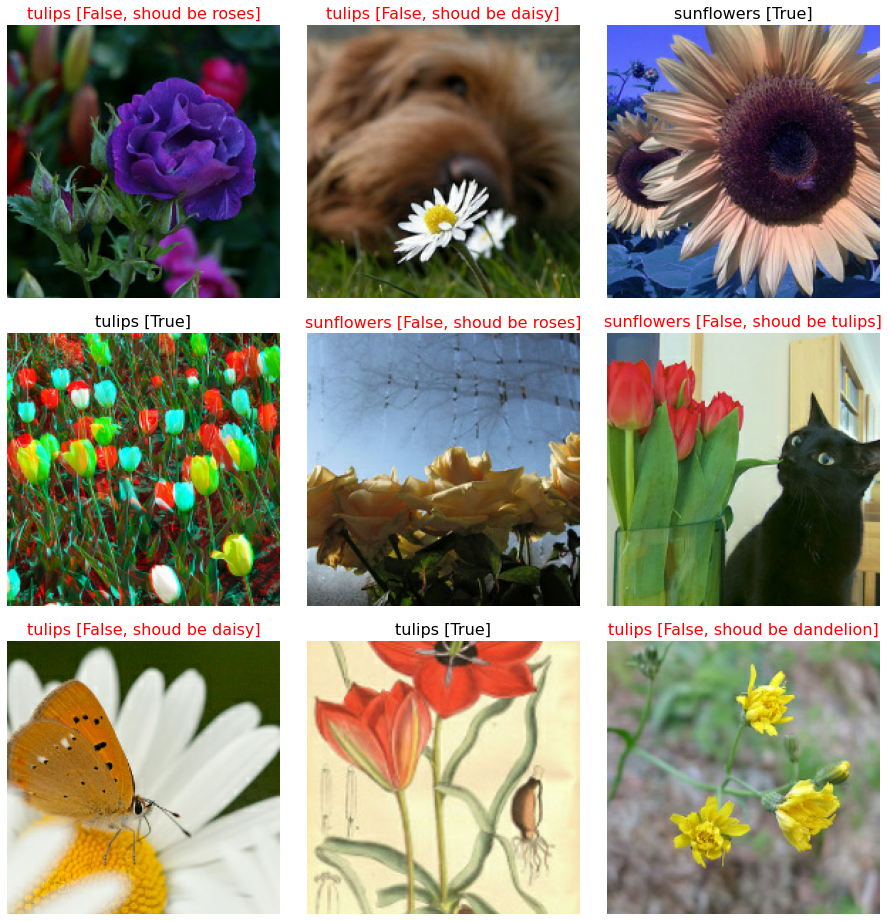

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## Task 4: Machine learning in the cloud (20%)

### 4a) Create the package and code for the AI-Platform (7%)

The AI Platform needs code in a 'package'. 
The package can contain complex software systems and extensive  information on the setup. 
We will keep the package as simple as possible here.



i) The minimal 'package' in Python needs a directory with two modules (i.e. Python files). 
Create a directory 'trainer' and then an empty file `trainer/__init__.py`. 
This can be done by using the command line tool `touch`. 
Check that the file exists. (1%) 

In [ ]:
### CODING TASK ###

# creating new directory
%cd "/content/drive/MyDrive/BD-CW"
!mkdir trainer # <-- commented when it has already been made

# changing to the created directory
%cd "/content/drive/MyDrive/BD-CW/trainer"

# creating new file within the new directory
!touch __init__.py

# checking existence of above file
os.path.isfile('/content/drive/MyDrive/BD-CW/trainer/__init__.py')

/content/drive/MyDrive/BD-CW
mkdir: cannot create directory ‘trainer’: File exists
/content/drive/MyDrive/BD-CW/trainer


True

ii) The other file we need is the modlue with the training code, which we will call `task.py`. 

We can build this file by combining the last few cells under 'Machine Learning Setup' into one file, almost literally. 

Then, we need to save the model itself and the training history into a file after training. 
The `history` object returned by `model.fit` can not be pickled, but it's data in `history.history` can. 
For saving the model, use `model.save()`.
Write the necessary code, like in section 2 when preparing jobs for Spark/DataProc.

If you use argparse as in section 2 (recommended), then you need to add an argument `--job-dir` that will be passed through from the AI-Platform to your program.
(6%)

In [ ]:
# changing to the created directory
%cd "/content/drive/MyDrive/BD-CW/trainer"

/content/drive/MyDrive/BD-CW/trainer


In [ ]:
%%writefile task4A.py

### CODING TASK ###

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
import tensorflow as tf
import pickle
import argparse
import datetime
import pandas as pd


AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
BATCH_SIZES = [32, 64, 128]

TRAINER_PACKAGE_PATH ="trainer"
MAIN_TRAINER_MODULE ="trainer.task4" # task4.py?

PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_TFR_PATTERN = BUCKET + '/tfrecords-jpeg-192x192-2/flowers*.tfrec' 

PACKAGE_STAGING_PATH = BUCKET

JOB_NAME ="4b_flowers_training" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

#CONFIG = 'standard_gpu'
CONFIG = 'complex_model_l_gpu'

TARGET_SIZE = [192,192]

VALIDATION_SPLIT = 0.25

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings

SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:] #< --- May need to shuffle tfrecords for training?
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))


## defining necessary functions ##

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def get_batched_dataset(filenames, bs, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(bs)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets


def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', should be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset


def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def task4a(argv, local = False):

  # collating the necesssary arguments
  print(argv)
  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                      help='The bucket URL for the result.') # add a required argument
  

  if local:
    EPOCHS = 3 # this value is for testing. Increase later
    print('performing ai-platform local train - epochs: {}'.format(EPOCHS))


  else:
    EPOCHS = 25
    print('Submitting to AI platform - epochs: {}'.format(EPOCHS))
    parser.add_argument('--job-dir', metavar = 'job_dir', required = True,
                      help = 'Necessary input for the AI platform.')

  # parsing arguments
  args = parser.parse_args(argv) # read the value

  df = pd.DataFrame(columns = ["batch size", "strategy", "cluster", "training time", "25 epoch accuracy", "max accuracy"])

  for bs in BATCH_SIZES:

    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // bs
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // bs
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

    # creating training/validation sets
    training_dataset = get_batched_dataset(training_filenames, bs = bs, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, bs = bs, train=False)


    # initialising a pre-trained model
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    # adding extra layers to pre-trained model, as per section 2
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    # starting timer
    tt0 = time.time()

    # training the model
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=validation_dataset, validation_steps=validation_steps)
    print('training finished')
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))

    # random input: execute multiple times to change results
    flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

    # making predictions
    predictions = model.predict(flowers, steps=1)
    
    # recording accuracy and loss for the current model after 25 epochs
    accuracy = history.history['accuracy'][-1]
    max_accuracy = max(history.history['accuracy'])

    # creating new row to add to dataframe
    new_row = pd.DataFrame({"batch size": bs, "strategy": ["None"], "cluster": CONFIG,\
                            "training time": tt, "25 epoch accuracy": accuracy,"max accuracy": max_accuracy})
    # adding to dataframe
    df = pd.concat([df, new_row], ignore_index = True)

    # naming the file in to which the model history will be saved
    if local:
      FILENAME = 'T4A_BS'+str(bs)+'_'+str(CONFIG)+'_local_test.pkl'
      DF_FILENAME = 'T4A_'+str(CONFIG)+'_local_df.pkl'
    else:
      FILENAME = 'T4A_BS'+str(bs)+'_'+str(CONFIG)+'.pkl'
      DF_FILENAME = 'T4A_'+str(CONFIG)+'_df.pkl'

    # saving the model and history #
    save(history.history, args.out_bucket, FILENAME)
    model.save(args.out_bucket)
  # saving the df
  save(df, args.out_bucket, DF_FILENAME)


# running the task4 function
if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task4a(sys.argv[1:], local = False)
elif __name__ == "__main__" : # but define them manually
    task4a(["--out_bucket", BUCKET], local = True)  
  

Overwriting task4A.py


### 4b) Run the Training on the AI-Platform and view the Output (3%)

Now, with all code in place, we can submit the package. AI-Platform is serverless, therefore we don't need to create a cluster ourselves, but we just submit a job and the master and workers will be set up automatically. 
Find [here](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training) the information how to submit a training job in GCS AI-Platform.  

The job will wait in a queue before it gets executed, this can take several minutes (at least on free credits). 
It's therefore a good idea to test the script locally before you submit to the cloud. 

You can, however, get powerful hardware. Up to 30 K80 or even P100 GPUs are available, but not all configurations are possible. 
Check [here](https://cloud.google.com/ai-platform/training/docs/quotas#gpu-quota) and [here](https://cloud.google.com/ai-platform/training/docs/using-gpus), and test [here on the console](https://console.cloud.google.com/ai-platform/create-job/custom-code?folder=true&organizationId=true) with the Create option whether your configuration works in the Google Cloud.


In [ ]:
# changin to correct directory
%cd "/content/drive/MyDrive/BD-CW"

# AI Platform parameters
PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)

PACKAGE_STAGING_PATH = BUCKET

TRAINER_PACKAGE_PATH ="trainer"
MAIN_TRAINER_MODULE ="trainer.task4A"

JOB_NAME ="Task4B_no_strategy_complex_gpu" # you need a new job name for every run
JOB_DIR = BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 

!gcloud ai-platform jobs submit training $JOB_NAME \
   --module-name $MAIN_TRAINER_MODULE \
   --staging-bucket $PACKAGE_STAGING_PATH \
   --package-path $TRAINER_PACKAGE_PATH \
   --runtime-version 2.1 \
   --python-version 3.5 \
   --master-machine-type complex_model_l_gpu \
   --scale-tier CUSTOM \
   -- --out_bucket $BUCKET --job-dir $JOB_DIR # <-- added custom arg(s)

/content/drive/MyDrive/BD-CW
Job [Task4B_no_strategy_complex_gpu] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Task4B_no_strategy_complex_gpu

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Task4B_no_strategy_complex_gpu
jobId: Task4B_no_strategy_complex_gpu
state: QUEUED


After training, plot the accuracy and loss curves based on the saved history.

Copying gs://big-data-cw-310516-storage/T4A_BS64_standard_gpu.pkl...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                
Operation completed over 1 objects/2.4 KiB.                                      


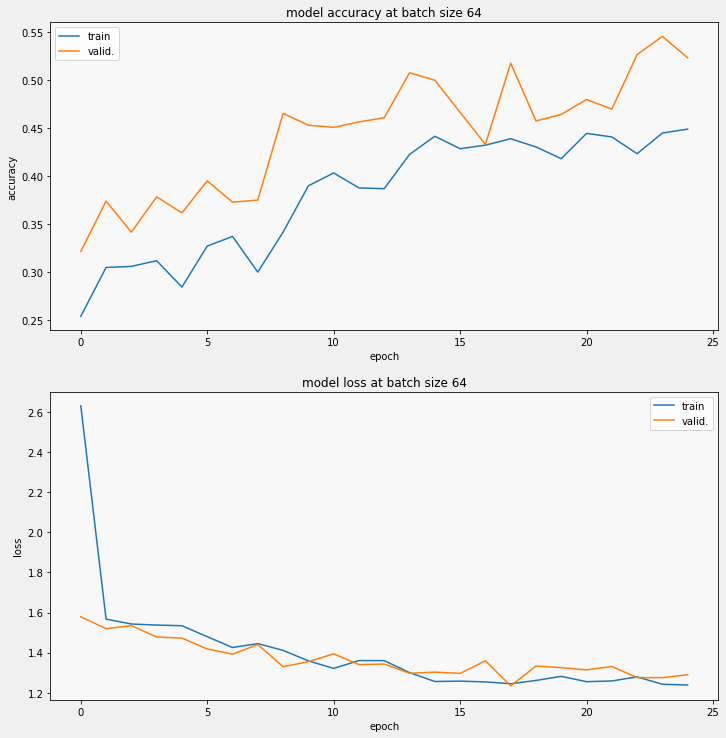

In [ ]:
### CODING TASK ###
def display_training_curves(training, validation, title, bs, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model {} at batch size {}'.format(title, bs))
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
 
# loading history of example model
FILENAME = 'T4A_BS64_standard_gpu.pkl'

batch_size = FILENAME.split('BS')[1].split('_')[0]

PATH = BUCKET+'/'+FILENAME
!gsutil cp $PATH .

with open(FILENAME, mode = 'rb') as f:
  history = pickle.load(f)

# plotting the accuracy and loss curves
display_training_curves(history['accuracy'], history['val_accuracy'], 'accuracy', batch_size, 211)
display_training_curves(history['loss'], history['val_loss'], 'loss', batch_size, 212)

### 4c) Distributed learning	(10%)

Apply a distributed learning strategy to the code (see https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras?hl=nb#choose_the_right_strategy for an example ).  
Add the necessary changes to the code.

Experiment with different strategies and batch sizes. Report and interpret your results. 
For the defining cluster sizes, you can use command line options as described here: https://cloud.google.com/ai-platform/training/docs/machine-types#legacy-machine-types . 
Check the pricing here ( https://cloud.google.com/ai-platform/training/pricing ) and make sure everything works before you run jobs on the expensive configurations. 

The machines with P100 and V100 GPUs are quite expensive. 
For the experiments here, the `standard_gpu` (1xK80) and the `complex_model_l_gpu` (8xK80) are sufficient.

In [ ]:
# changing to the created directory
%cd "/content/drive/MyDrive/BD-CW/trainer"

/content/drive/MyDrive/BD-CW/trainer


In [ ]:
%%writefile task4C.py

### CODING TASK ###

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
import tensorflow as tf
import pickle
import argparse
import datetime
import pandas as pd

# initialising stable variables #
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

#BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)

REGION = 'us-centrall'

TRAINER_PACKAGE_PATH ="trainer"
MAIN_TRAINER_MODULE ="trainer.task4" # task4.py?

PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_TFR_PATTERN = BUCKET + '/tfrecords-jpeg-192x192-2/flowers*.tfrec' 

PACKAGE_STAGING_PATH = BUCKET

JOB_NAME ="4C_flowers_training" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

TARGET_SIZE = [192,192]

VALIDATION_SPLIT = 0.25

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings

SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

BATCH_SIZES = [32, 64, 128, 256, 512]

#CONFIG = 'complex_model_l_gpu'
CONFIG = 'standard_gpu_4_workers'

STRATEGY = tf.distribute.experimental.MultiWorkerMirroredStrategy()
STRAT_NAME = "MultiWorkerMirrored"

#STRATEGY = tf.distribute.MirroredStrategy()
#STRAT_NAME = "Mirrored"

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:] #< --- May need to shuffle tfrecords for training?
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))


## defining necessary functions ##

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def get_batched_dataset(filenames, bs, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(bs)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets


def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', should be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  options = tf.data.Options()
  options.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(options)
  dataset = dataset.map(read_tfrecord)
  return dataset


def save(object,bucket,filename):
  with open(filename,mode='wb') as f:
    pickle.dump(object,f)    
  print("Saving {} to {}".format(filename,bucket))
  import subprocess
  proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
  print("gstuil returned: " + str(proc.returncode))
  print(str(proc.stderr))


def task4c(argv, local = False):

  # collating the necesssary arguments
  print(argv)
  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                      help='The bucket URL for the result.') # add a required argument
  
  if local:
    EPOCHS = 3 # this value is for testing. Increase later
    print('performing ai-platform local train - epochs: {}'.format(EPOCHS))

  else:
    EPOCHS = 25
    print('Submitting to AI platform - epochs: {}'.format(EPOCHS))
    parser.add_argument('--job-dir', metavar = 'job_dir', required = True,
                      help = 'Necessary input for the AI platform.')
    
  # parsing arguments
  args = parser.parse_args(argv) # read the value
  # intitialising dataframe for table
  df = pd.DataFrame(columns = ["batch size", "strategy", "cluster", "training time", "25 epoch accuracy", "max accuracy"])
  
  for each in BATCH_SIZES:
    # delcaring the strategy
    strategy = STRATEGY
    BATCH_SIZE = each

    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

    # creating training/validation sets
    training_dataset = get_batched_dataset(training_filenames, train=True, bs = BATCH_SIZE)
    validation_dataset = get_batched_dataset(validation_filenames, train=False, bs = BATCH_SIZE)


    # building a model under specific strategy
    with strategy.scope():
      # initialising a pre-trained model
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False

      # adding extra layers to pre-trained model, as per section 2
      model = tf.keras.Sequential([
          pretrained_model,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dropout(.5),
          tf.keras.layers.Dense(5, activation='softmax')
      ])

      model.compile(
          optimizer='adam',
          loss = 'sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      model.summary()

      # printing to know when each model was being trained for reference to ai-platform job details
      print("training mdl with: {} strategy, {} batch size, and {} config".format(STRAT_NAME, BATCH_SIZE, CONFIG))
        
      # starting timer for training
      tt0 = time.time()

      # printing the time each model training started
      correct_t = tt0 + 60*60
      print(time.strftime("%I:%M %p",time.localtime(correct_t)))

      # training the model
      history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                          validation_data=validation_dataset, validation_steps=validation_steps)
      print('training finished at {}'.format(time.strftime("%I:%M %p",time.localtime(time.time()+ 60*60))))

      # recording training time
      tt = time.time() - tt0
      print("Wall clock time = {}".format(tt))

      # random input: execute multiple times to change results
      flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

      # making predictions
      predictions = model.predict(flowers, steps=1)
      print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

      # recording accuracy and loss for the current model after 25 epochs
      accuracy = history.history['accuracy'][-1]
      max_accuracy = max(history.history['accuracy'])

      # creating new row to add to dataframe
      new_row = pd.DataFrame({"batch size": BATCH_SIZE, "strategy": STRAT_NAME, "cluster": CONFIG,\
                                "training time": tt, "25 epoch accuracy": accuracy,"max accuracy": max_accuracy},\
                             index = [0])
      # adding to dataframe
      df = pd.concat([df, new_row], ignore_index = True)


      # naming the file in to which the model history and results will be saved
      if local:
        FILENAME = 'T4C_'+str(STRAT_NAME)+'_'+'BS'+str(each)+'_'+str(CONFIG)+'_local_test.pkl'
        DF_FILENAME = 'T4C_'+str(STRAT_NAME)+'_'+'BS'+str(each)+'_'+str(CONFIG)+'_local_df.pkl'
      else:
        FILENAME = 'T4C_multiStrat_'+str(STRAT_NAME)+'_'+'BS'+str(each)+'_'+str(CONFIG)+'.pkl'
        DF_FILENAME = 'T4C_multiStrat_'+str(STRAT_NAME)+'_'+'BS'+str(each)+'_'+str(CONFIG)+'_df.pkl'

      # saving the model, history, and table metrics #
      save(history.history, args.out_bucket, FILENAME)
      model.save(args.out_bucket+'/'+str(STRAT_NAME)+'_'+str(BATCH_SIZE)+'_mdl')

  save(df, args.out_bucket, str(STRAT_NAME)+'_'+str(CONFIG)+"_df.pkl") 

# running the task4 function
if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task4c(sys.argv[1:], local = False)
elif __name__ == "__main__" : # but define them manually
    task4c(["--out_bucket", BUCKET], local = True)  

Overwriting task4C.py


In [ ]:
# changing to correct directory
%cd "/content/drive/MyDrive/BD-CW"

# AI Platform parameters
PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)

PACKAGE_STAGING_PATH = BUCKET

REGION = 'us-centrall'

TRAINER_PACKAGE_PATH ="trainer"
MAIN_TRAINER_MODULE ="trainer.task4C"

JOB_NAME ="Task4C_mirrored3" # you need a new job name for every run
JOB_DIR = BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 

!gcloud ai-platform jobs submit training $JOB_NAME \
   --module-name $MAIN_TRAINER_MODULE \
   --staging-bucket $PACKAGE_STAGING_PATH \
   --package-path $TRAINER_PACKAGE_PATH \
   --runtime-version 2.1 \
   --python-version 3.5 \
   --scale-tier CUSTOM \
   --master-machine-type complex_model_l_gpu \
   -- --out_bucket $BUCKET --job-dir $JOB_DIR  # <-- added custom arg(s)

/content/drive/MyDrive/BD-CW
Job [Task4C_mirrored3] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Task4C_mirrored3

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Task4C_mirrored3
jobId: Task4C_mirrored3
state: QUEUED


In [ ]:
# changing to correct directory
%cd "/content/drive/MyDrive/BD-CW"

# AI Platform parameters
PROJECT = 'big-data-cw-310516'
BUCKET = 'gs://{}-storage'.format(PROJECT)

PACKAGE_STAGING_PATH = BUCKET

TRAINER_PACKAGE_PATH ="trainer"
MAIN_TRAINER_MODULE ="trainer.task4C"

JOB_NAME ="Task4C_multiworkerMirrored6" # you need a new job name for every run
JOB_DIR = BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 

!gcloud ai-platform jobs submit training $JOB_NAME \
   --module-name $MAIN_TRAINER_MODULE \
   --staging-bucket $PACKAGE_STAGING_PATH \
   --package-path $TRAINER_PACKAGE_PATH \
   --runtime-version 2.1 \
   --python-version 3.5 \
   --scale-tier CUSTOM \
   --master-machine-type standard_gpu \
   --worker-machine-type standard_gpu --worker-count 7 \
   -- --out_bucket $BUCKET --job-dir $JOB_DIR  # <-- added custom arg(s)

/content/drive/MyDrive/BD-CW
Job [Task4C_multiworkerMirrored6] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Task4C_multiworkerMirrored6

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Task4C_multiworkerMirrored6
jobId: Task4C_multiworkerMirrored6
state: QUEUED


After you have run the experiments, copy the results over from the bucket to the local file system, so that you can extract the values for a table.

In [ ]:
### CODING TASK ### 
# Read output from jobs
import pandas as pd

# loading history of example model
FILENAMES = ['T4A_complex_model_l_gpu_df.pkl', 'T4A_standard_gpu_df.pkl',\
             'Mirrored_complex_model_l_gpu_df.pkl', 'MultiWorkerMirrored_standard_gpu_4_workers_df.pkl']

# initialising list
list = []

# loading the DFs in to the list
for name in FILENAMES:
  PATH = BUCKET+'/'+name
  !gsutil cp $PATH .

  with open(name, mode = 'rb') as f:
    dic = pickle.load(f)
    list.append(dic)

# appending all of the dataframes
df = pd.concat(list, ignore_index = True)

# exporting dataframe to excel table for formatting
%cd "/content/drive/MyDrive/BD-CW"
df.to_excel("NN_table.xlsx")
df


Copying gs://big-data-cw-310516-storage/T4A_complex_model_l_gpu_df.pkl...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      
Copying gs://big-data-cw-310516-storage/T4A_standard_gpu_df.pkl...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      
Copying gs://big-data-cw-310516-storage/Mirrored_complex_model_l_gpu_df.pkl...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      
Copying gs://big-data-cw-310516-storage/MultiWorkerMirrored_standard_gpu_4_workers_df.pkl...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      
/content/drive/MyDrive/BD-CW


batch size             strategy  ... 25 epoch accuracy  max accuracy
0          32                 None  ...          0.361765      0.361765
1          64                 None  ...          0.308408      0.319940
2         128                 None  ...          0.519345      0.519345
3          32                 None  ...          0.243015      0.256250
4          64                 None  ...          0.449033      0.449033
5         128                 None  ...          0.486979      0.486979
6          32             Mirrored  ...          0.241912      0.258456
7          64             Mirrored  ...          0.399182      0.409598
8         128             Mirrored  ...          0.501860      0.501860
9         256             Mirrored  ...          0.445703      0.445703
10        512             Mirrored  ...          0.348047      0.355469
11         32  MultiWorkerMirrored  ...          0.352941      0.352941
12         64  MultiWorkerMirrored  ...          0.401042      0.419271
13        128  MultiWorkerMirrored  ...          0.363095      0.369048
14        256  MultiWorkerMirrored  ...          0.326172      0.326172
15        512  MultiWorkerMirrored  ...          0.390234      0.390234

[16 rows x 6 columns]

# Section 3. Theoretical discussion

## Task 5: Discussion in context. (20%)

In this task we refer to two ideas,what are introduced in these two papers:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).
-	Smith, S. L., Kindermans, P. J., Ying, C., & Le, Q. V. (2018). [Don't Decay the Learning Rate, Increase the Batch Size.](https://openreview.net/pdf?id=B1Yy1BxCZ) In ICLR (no pagination).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given task. 
Smith et al (2018) introduce the concept of varying the batch size during the training of neural networks. 

### 5a)	Contextualise

Relate the previous tasks and the results to these two concepts. (It is not necessary to work through the details of the papers, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply for this task? (10%)

### 5b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, on-line, stream) discuss general relationship with the two concepts above. (10%)

Provide the answers to these questions in your report. 


online notebook link: https://colab.research.google.com/drive/1Qo7bIWyn39okzb2V2OBs9rSMi59pk_ET?usp=sharing 